In [13]:
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
np.random.seed(42)

# System Parameters
T = 10  # Time slots
K = 30  # Number of UEs
N = 10  # Number of nodes
C = 6   # Number of satellites
A = 10  # Number of areas for SAR coverage

# Channel Model Parameters
P_n = 10.0  # Transmission power (W)
G_n = 20.0  # Antenna gain (dB)
G_m = 15.0  # Receiver gain (dB)
N_noise = 1e-9  # Noise power (W)
B = 10e6  # Bandwidth (Hz)
gamma_A = 0.1  # Specific attenuation (dB/km)
L_n = 5.0  # Effective path length (km)
A_exp = 0.8  # Attenuation exponent

# Cost and Latency Parameters (Sized for N=30 and C=6)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1  # Weights
Cost_local = np.random.uniform(1.0, 2.0, N).tolist()  # Local processing cost per node
Cost_bh = np.random.uniform(1.0, 3.0, (N, N))  # Backhaul cost
tau_local = np.random.uniform(0.1, 0.2, N).tolist()  # Local processing latency
tau_bh = np.random.uniform(0.1, 0.5, (N, N))  # Backhaul latency
E_SAR = np.random.uniform(5.0, 6.0, C).tolist()  # Energy cost for SAR per satellite
d_k = np.random.uniform(1e6, 2e6, K).tolist()  # Data rate requirements for UEs (bps)
d_SAR = np.random.uniform(3e6, 4e6, C).tolist()  # Data rate for SAR (bps)

# Availability Parameters
v_c_t = np.random.binomial(1, 0.8, (C, T))  # Satellite availability
g_n_t = np.random.binomial(1, 0.5, (N, T))  # Gateway availability
b_c_a_t = np.random.binomial(1, 0.7, (C, A, T))  # SAR coverage availability

# Calculate SNR and Capacity
def calculate_rain_attenuation(p):
    return gamma_A * L_n * (p / 0.01) ** A_exp

def calculate_snr(p, distance):
    rain_att = 10 ** (-calculate_rain_attenuation(p) / 10)
    free_space_loss = (4 * np.pi * distance * 1e6 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return snr

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

# Precompute capacities
C_n_t = np.zeros((N, T))
for n in range(N):
    for t in range(T):
        snr = calculate_snr(0.01, 1000)  # Assume 1000 km distance
        C_n_t[n, t] = calculate_capacity(snr)

# Optimization Problem
prob = LpProblem("Border_Surveillance_Optimization", LpMinimize)

# Variables
a_k_n_t = LpVariable.dicts("a", [(k, n, t) for k in range(K) for n in range(N) for t in range(T)], cat='Binary')
x_n_t = LpVariable.dicts("x", [(n, t) for n in range(N) for t in range(T)], cat='Binary')
l_n_t = LpVariable.dicts("l", [(n, t) for n in range(N) for t in range(T)], cat='Binary')
r_n_m_t = LpVariable.dicts("r", [(n, m, t) for n in range(N) for m in range(N) for t in range(T)], cat='Binary')
s_c_t = LpVariable.dicts("s", [(c, t) for c in range(C) for t in range(T)], cat='Binary')
latency_aux = LpVariable.dicts("latency_aux", [(k, n, t) for k in range(K) for n in range(N) for t in range(T)], lowBound=0)
coverage_aux = LpVariable.dicts("coverage_aux", [(k, n, t) for k in range(K) for n in range(N) for t in range(T)], cat='Binary')

# Objective Function Components per Time Slot
local_cost_t = [lpSum(Cost_local[n] * l_n_t[n, t] for n in range(N)) for t in range(T)]
bh_cost_t = [lpSum(Cost_bh[n, m] * r_n_m_t[n, m, t] for n in range(N) for m in range(N)) for t in range(T)]
latency_t = [lpSum(latency_aux[k, n, t] for k in range(K) for n in range(N)) for t in range(T)]
sar_energy_t = [lpSum(E_SAR[c] * s_c_t[c, t] for c in range(C)) for t in range(T)]

# Total Objective
prob += lpSum(lambda_1 * local_cost_t[t] + lambda_2 * bh_cost_t[t] + 
              lambda_3 * latency_t[t] + lambda_4 * sar_energy_t[t] for t in range(T))

# Constraints
# Coverage Constraint (Linearized)
for k in range(K):
    for t in range(T):
        prob += lpSum(coverage_aux[k, n, t] for n in range(N)) == 1
        for n in range(N):
            prob += coverage_aux[k, n, t] <= a_k_n_t[k, n, t]
            prob += coverage_aux[k, n, t] <= x_n_t[n, t]
            prob += coverage_aux[k, n, t] >= a_k_n_t[k, n, t] + x_n_t[n, t] - 1
            prob += x_n_t[n, t] >= a_k_n_t[k, n, t]

# Local Core Functionality
for n in range(N):
    for t in range(T):
        prob += l_n_t[n, t] + lpSum(r_n_m_t[n, m, t] for m in range(N)) >= x_n_t[n, t]
        prob += g_n_t[n, t] * x_n_t[n, t] >= l_n_t[n, t]

# Satellite Backhaul Feasibility
for n in range(N):
    for c in range(C):
        for t in range(T):
            prob += r_n_m_t[n, c, t] <= v_c_t[c, t]

# Relaying Constraint
for t in range(T):
    for m in range(N):
        prob += (g_n_t[m, t] - 1) * lpSum(r_n_m_t[n, m, t] for n in range(N)) >= 0

# Capacity Constraint
for n in range(N):
    for t in range(T):
        prob += (lpSum(d_k[k] * a_k_n_t[k, n, t] for k in range(K)) + 
                 lpSum(d_SAR[c] * s_c_t[c, t] for c in range(C) if n == c)) <= x_n_t[n, t] * C_n_t[n, t]

# SAR Availability
for c in range(C):
    for t in range(T):
        prob += s_c_t[c, t] <= v_c_t[c, t]

# SAR Overlap Avoidance
for t in range(T):
    for a in range(A):
        prob += lpSum(b_c_a_t[c, a, t] * s_c_t[c, t] for c in range(C)) <= 1

# SAR Coverage
for a in range(A):
    prob += lpSum(b_c_a_t[c, a, t] * s_c_t[c, t] for c in range(C) for t in range(T)) >= 1

# Latency Linearization
M = 1000  # Big-M constant
for k in range(K):
    for n in range(N):
        for t in range(T):
            prob += latency_aux[k, n, t] >= (tau_local[n] * l_n_t[n, t] + 
                                             lpSum(tau_bh[n, m] * r_n_m_t[n, m, t] for m in range(N))) - M * (1 - a_k_n_t[k, n, t])
            prob += latency_aux[k, n, t] <= (tau_local[n] * l_n_t[n, t] + 
                                             lpSum(tau_bh[n, m] * r_n_m_t[n, m, t] for m in range(N))) + M * (1 - a_k_n_t[k, n, t])
            prob += latency_aux[k, n, t] <= M * a_k_n_t[k, n, t]

# Solve with timing
start_time = time.time()
prob.solve()
end_time = time.time()

# Extract results
local_cost_vals = [value(local_cost_t[t]) for t in range(T)]
bh_cost_vals = [value(bh_cost_t[t]) for t in range(T)]
latency_vals = [value(latency_t[t]) for t in range(T)]
sar_energy_vals = [value(sar_energy_t[t]) for t in range(T)]
objective_vals = [lambda_1 * local_cost_vals[t] + lambda_2 * bh_cost_vals[t] + 
                  lambda_3 * latency_vals[t] + lambda_4 * sar_energy_vals[t] for t in range(T)]

# Print results
print(f"Status: {prob.status} (1=Optimal, -1=Infeasible)")
print(f"Total Objective Value: {value(prob.objective):.2f}")
print(f"Solve Time: {end_time - start_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 8))
time_slots = np.arange(T)
plt.plot(time_slots, local_cost_vals, label='Local Processing Cost', marker='o')
plt.plot(time_slots, bh_cost_vals, label='Backhaul Cost', marker='s')
plt.plot(time_slots, latency_vals, label='Latency Cost', marker='^')
plt.plot(time_slots, sar_energy_vals, label='SAR Energy Cost', marker='d')
plt.plot(time_slots, objective_vals, label='Total Objective Value', marker='*', linestyle='--')
plt.xlabel('Time Slot')
plt.ylabel('Cost/Value')
plt.title('Performance Metrics Over Time Slots (Large Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Sep 26 2023 

command line - /home/ubuntu/miniconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/arm64/cbc /tmp/a2e03887e0e24baa92ef0f5a294ff263-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/a2e03887e0e24baa92ef0f5a294ff263-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 72675 COLUMNS
At line 734797 RHS
At line 807468 BOUNDS
At line 831929 ENDATA
Problem MODEL has 72670 rows, 34460 columns and 598941 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.63877 - 1.71 seconds
Cgl0002I 252 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 19846 strengthened rows, 20000 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 9729 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 6800 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 7052 

KeyboardInterrupt: 

In [18]:
!pip install pulp numpy matplotlib

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -34.6    |
| time/              |          |
|    fps             | 29       |
|    iterations      | 1        |
|    time_elapsed    | 68       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -35         |
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 2           |
|    time_elapsed         | 147         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.036080196 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss   

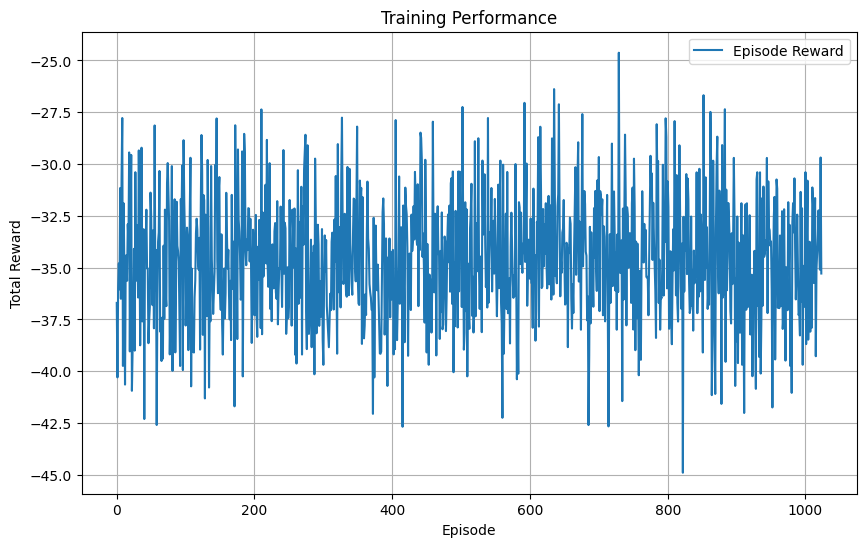

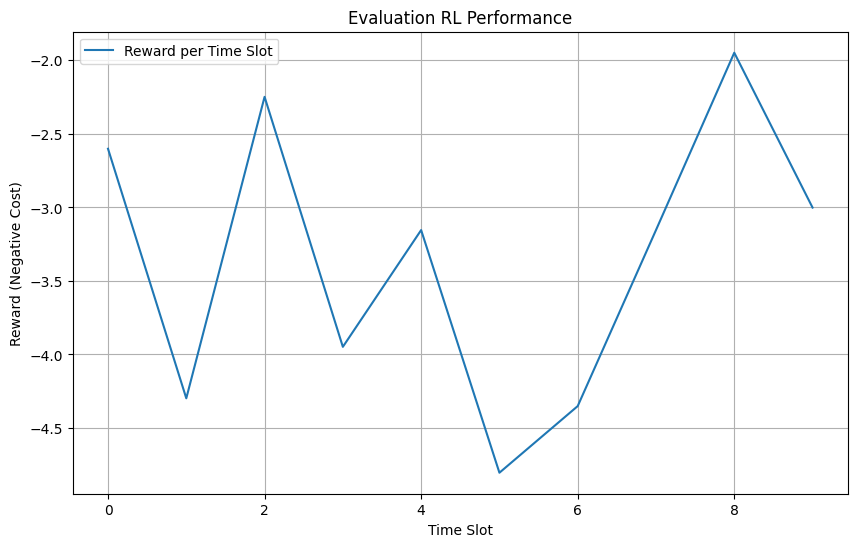

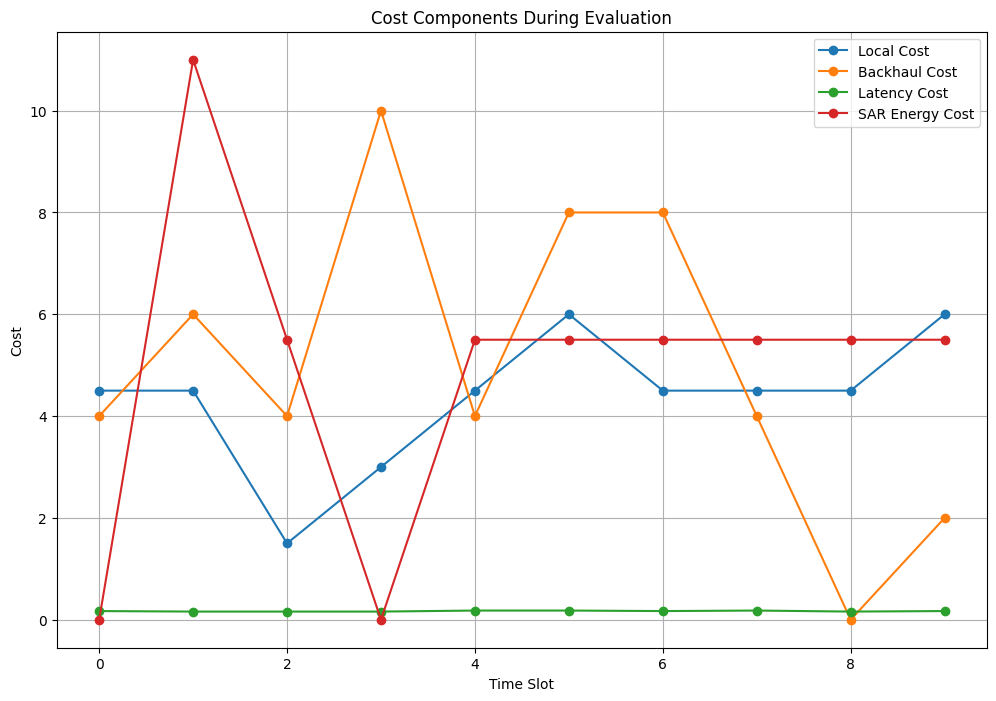

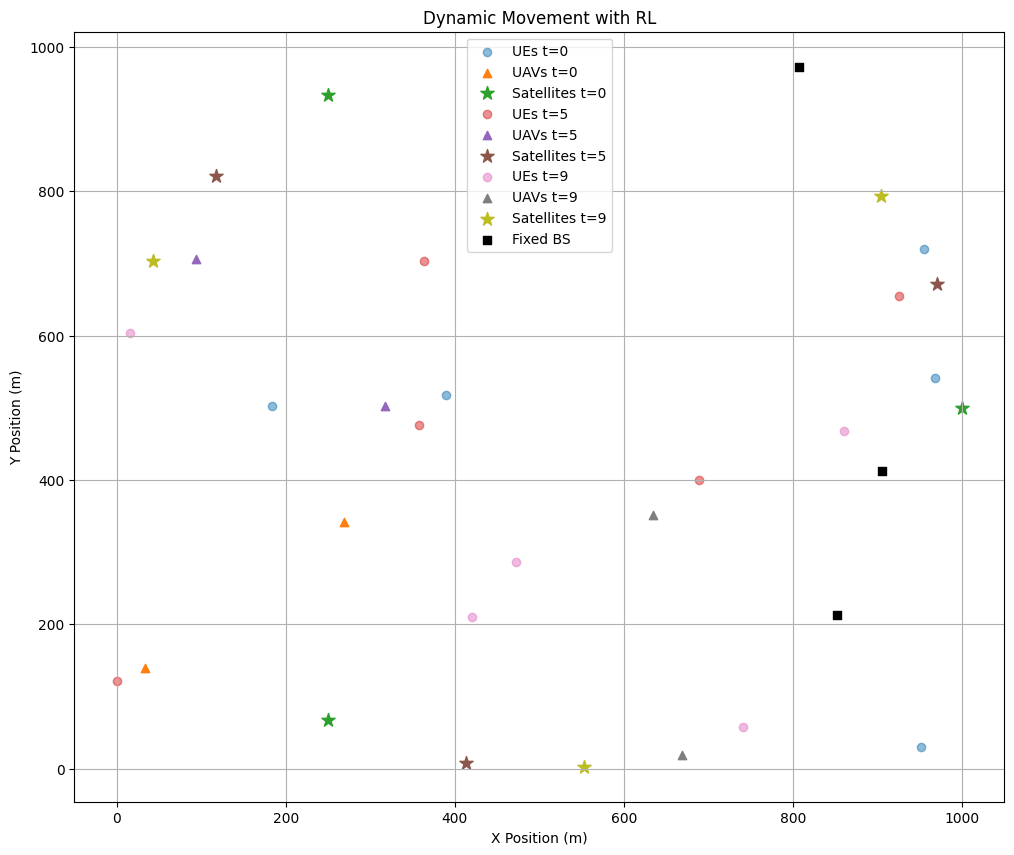

In [1]:
!pip install stable-baselines3 gymnasium torch stable-baselines3
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
T = 10
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

# Custom Callback for Logging Training Performance
class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

# Custom Environment
class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.T = T
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}  # Track costs
        self.reset()

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, T)), np.zeros((K, T))
        self.uav_x, self.uav_y = np.zeros((N // 2, T)), np.zeros((N // 2, T))
        self.sat_x, self.sat_y = np.zeros((C, T)), np.zeros((C, T))
        for t in range(T):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, T))
        for t in range(T):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}  # Reset costs
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy)

        # Log costs
        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= T
        truncated = False
        if not done:
            self.state = np.concatenate([self.uav_x[:, self.t], self.sat_x[:, self.t],self.ue_x[:, self.t],
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO with Callback
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu')
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, T//2, T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -34.7    |
| time/              |          |
|    fps             | 803      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -34.9      |
| time/                   |            |
|    fps                  | 639        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03217321 |
|    clip_fraction        | 0.424      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

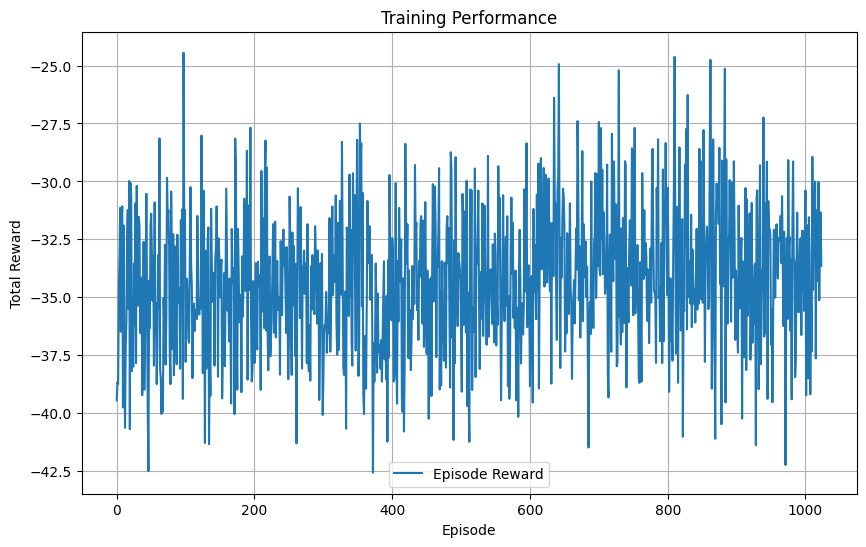

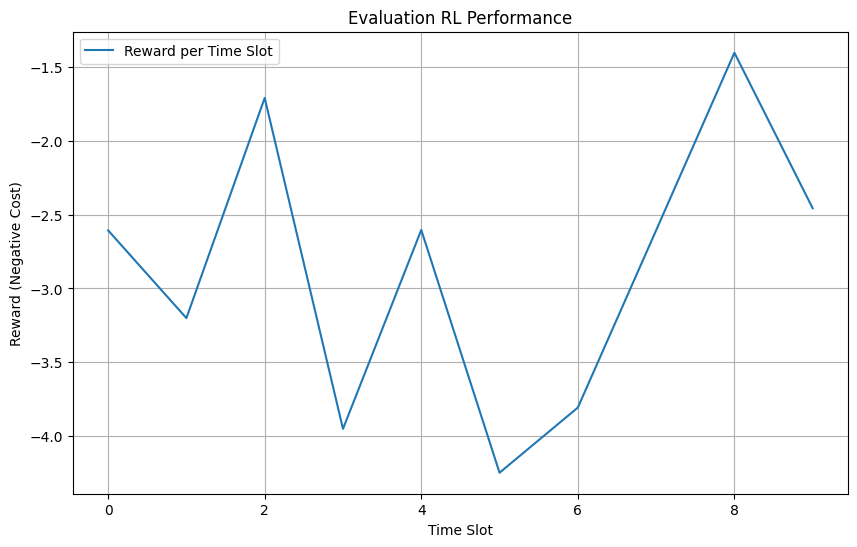

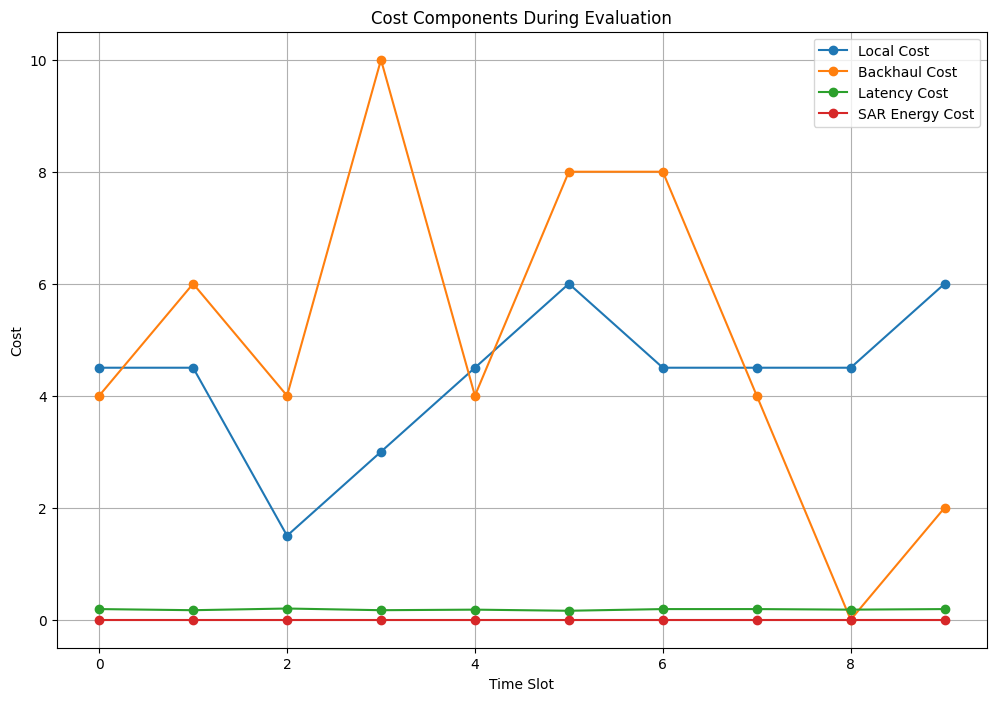

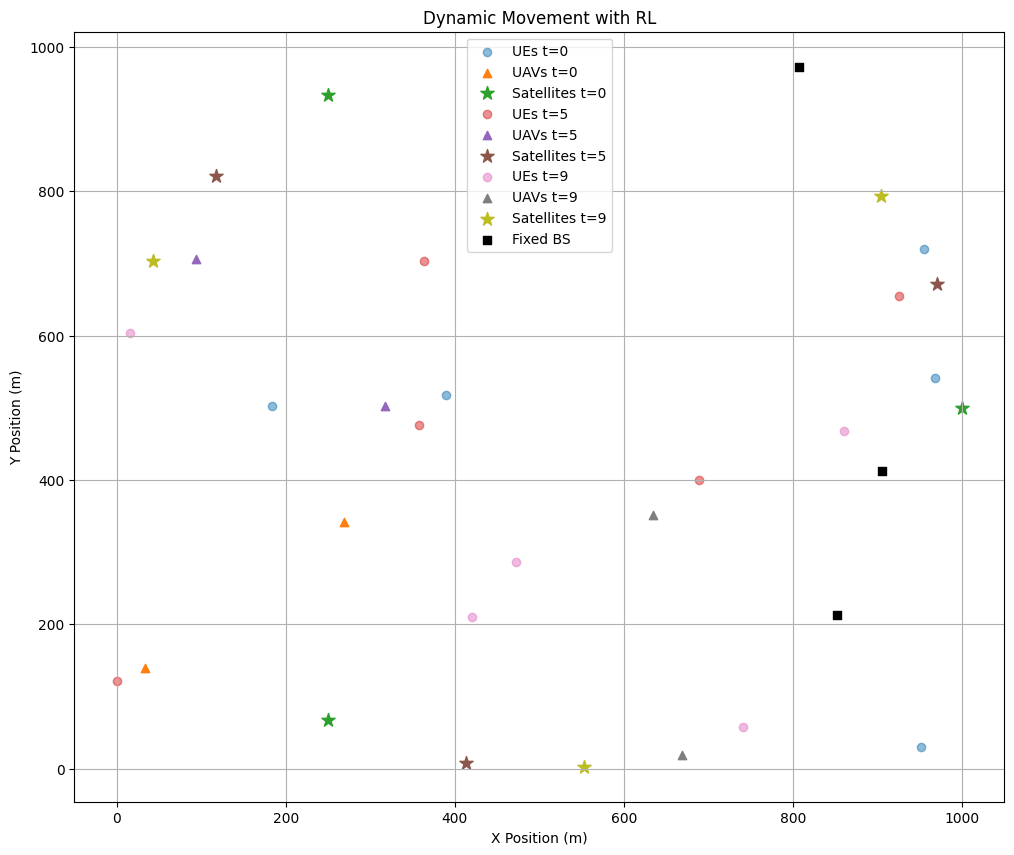

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5    # UEs
N = 5    # Nodes (N/2 UAVs, N-N/2 fixed BS)
C = 3    # Satellites
A = 2    # SAR areas
AREA_SIZE = 1000
MAX_T = 10  # Max time steps for evaluation (not in state/action)

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

# Training Logger Callback
class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

# Custom Environment (Single Time Step)
class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        # Precompute positions for all t, but only current t in state
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy)

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu')
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -49.2    |
| time/              |          |
|    fps             | 799      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -46.8      |
| time/                   |            |
|    fps                  | 640        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03552967 |
|    clip_fraction        | 0.429      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

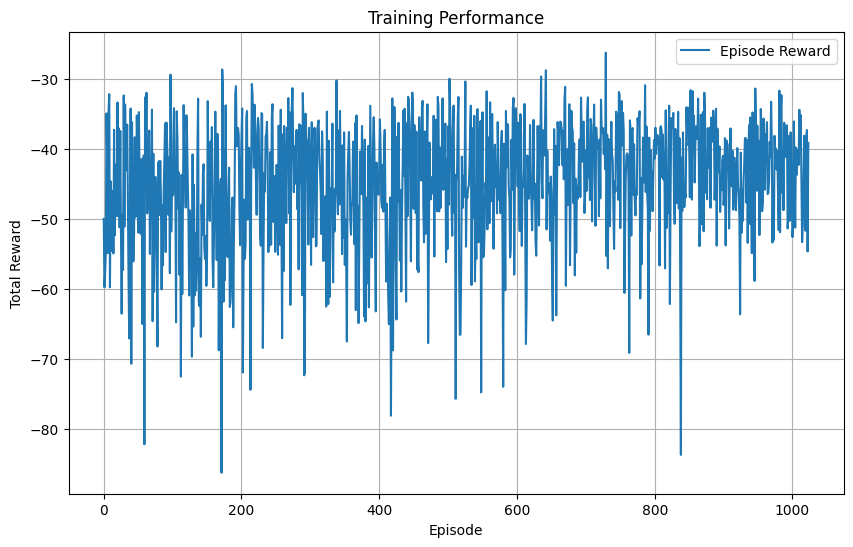

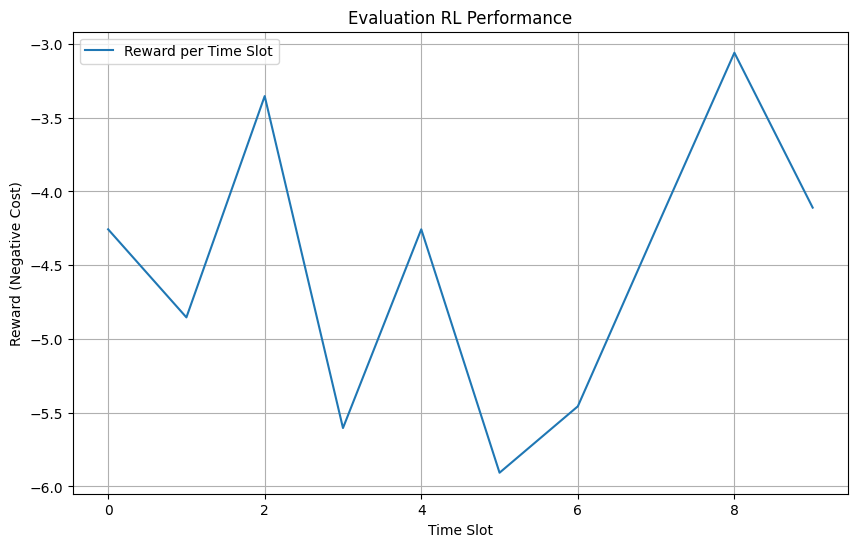

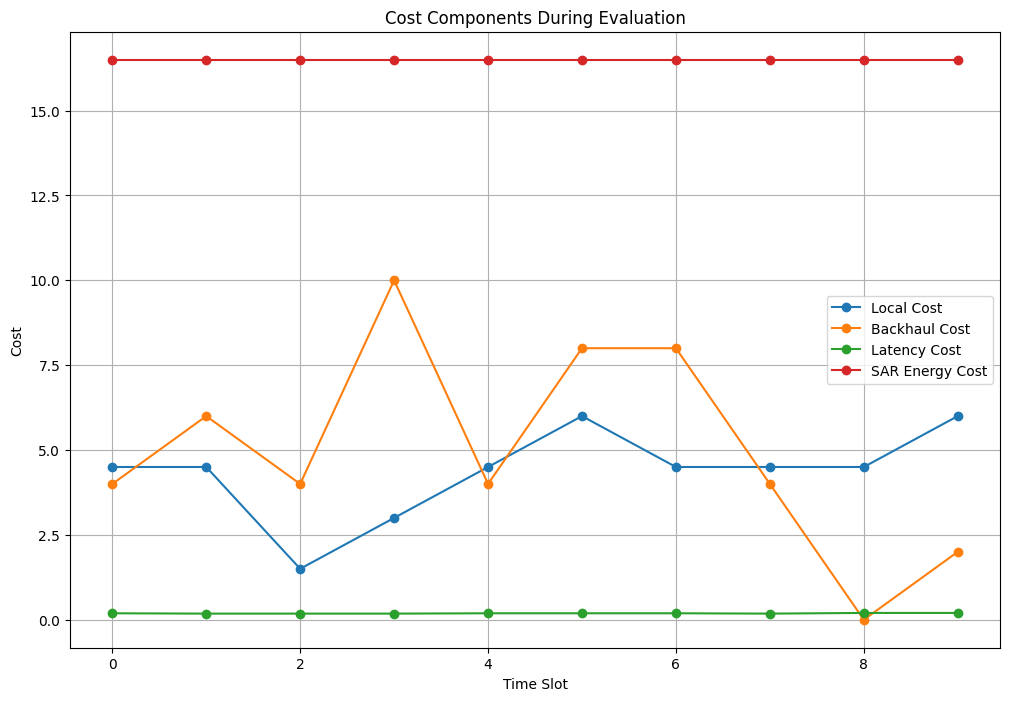

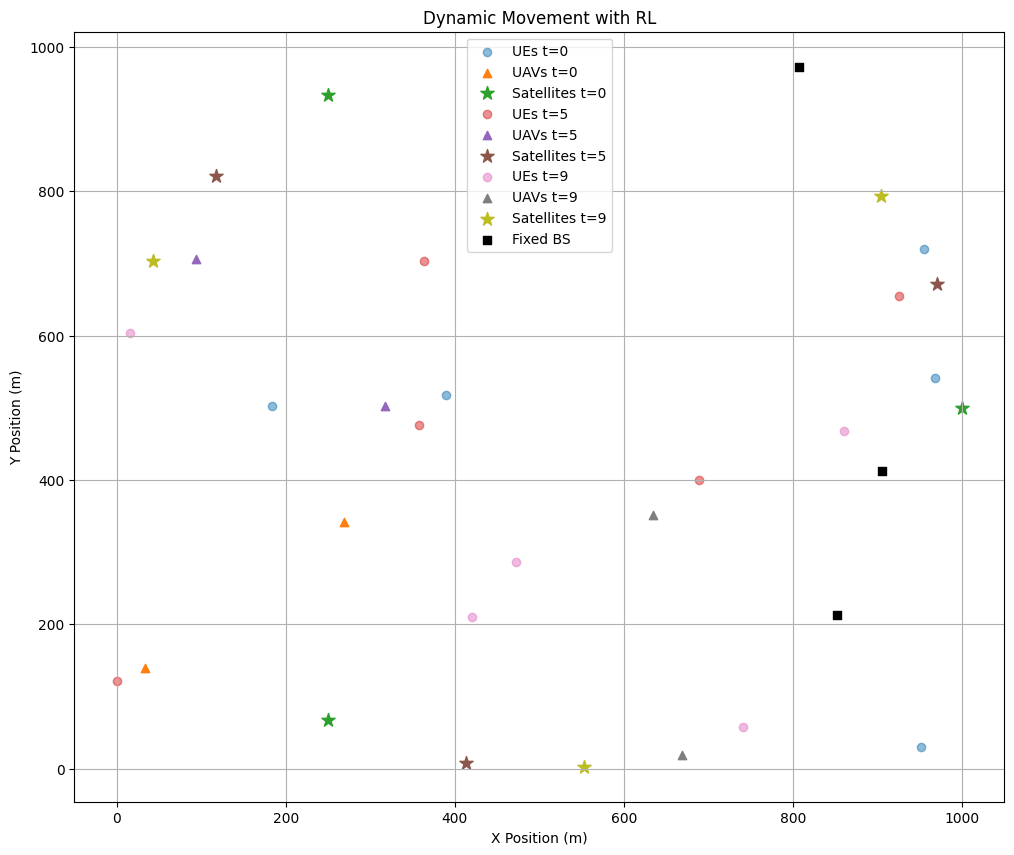

In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000
MAX_T = 10

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        sar_penalty = -10.0 if sum(sar_active) == 0 else 0.0
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu', ent_coef=0.01)
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -84.3    |
| time/              |          |
|    fps             | 677      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -79.4       |
| time/                   |             |
|    fps                  | 588         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.044392303 |
|    clip_fraction        | 0.467       |
|    clip_range           | 0.2         |
|    entropy_loss   

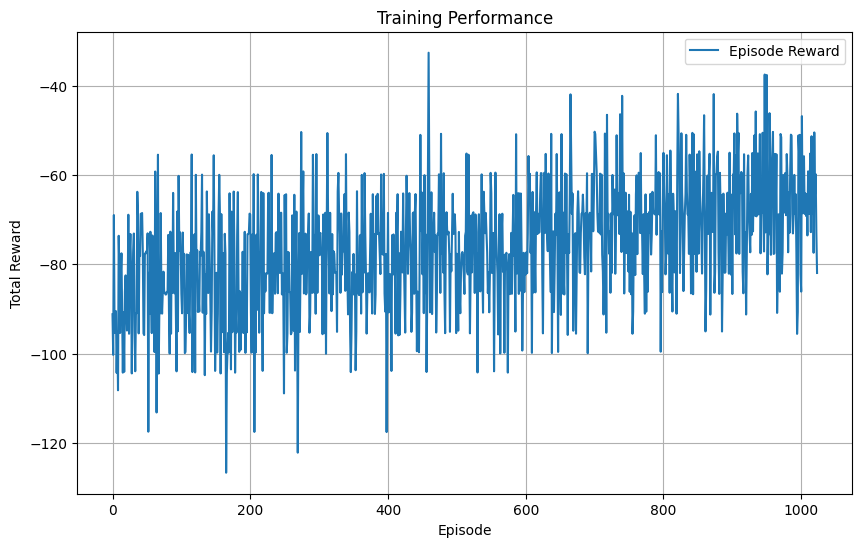

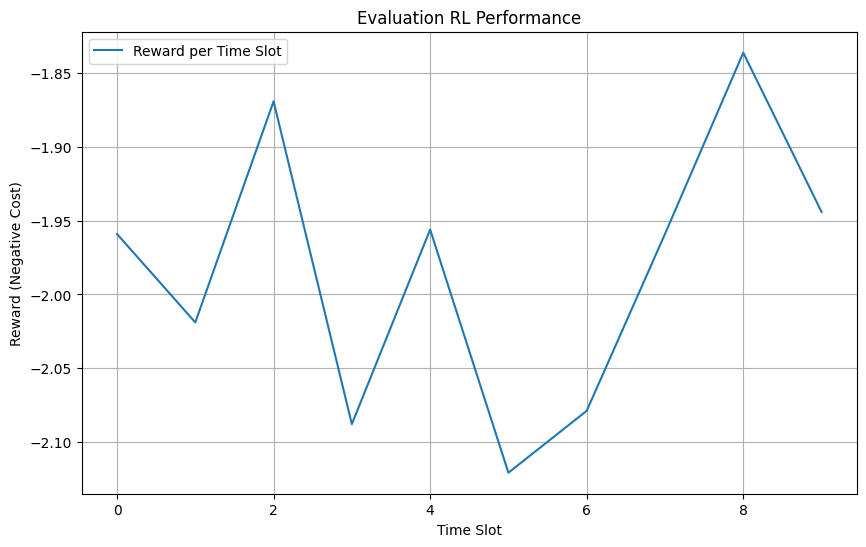

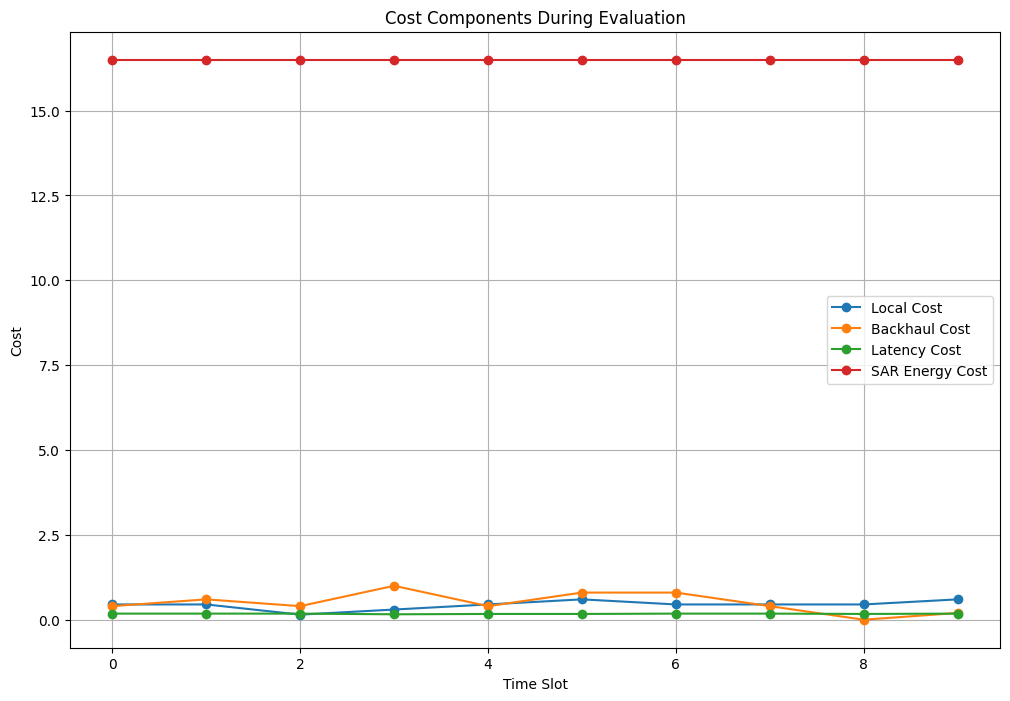

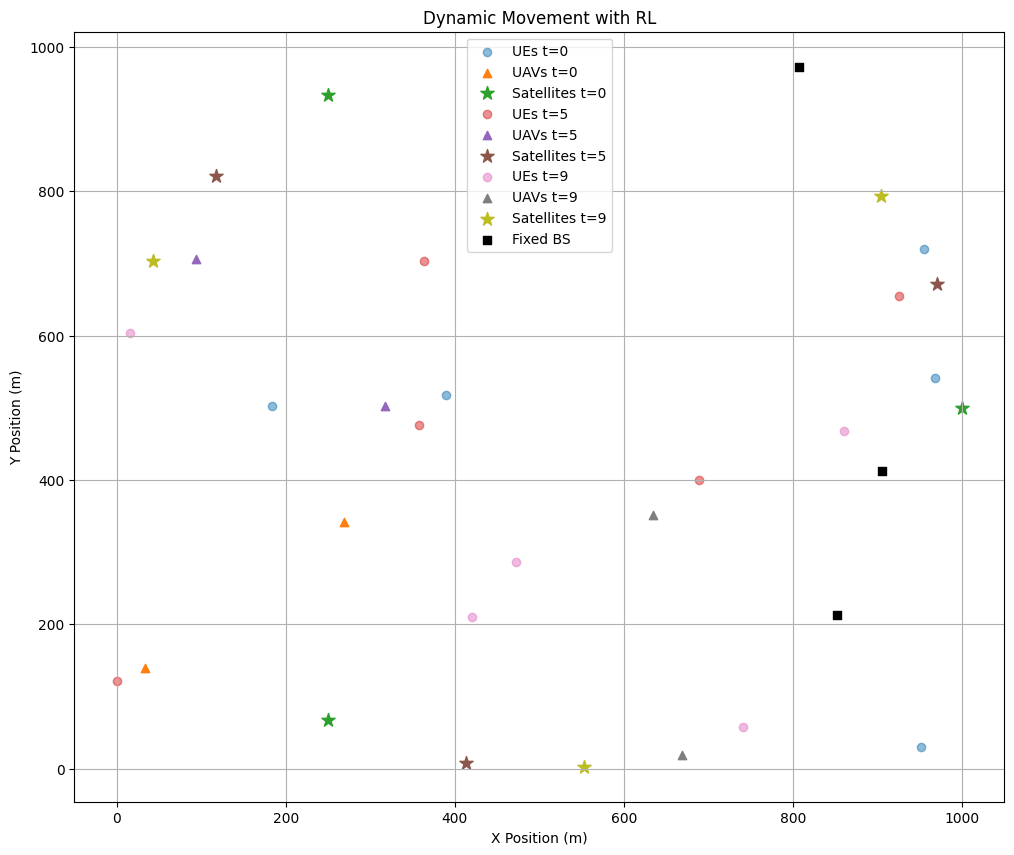

In [8]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000
MAX_T = 10

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = 0.1*np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = 0.1*np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        # Graduated penalty based on number of inactive SARs
        sar_penalty = -5.0 * (self.C - sum(sar_active))
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu', ent_coef=0.1)
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | -111     |
| time/              |          |
|    fps             | 874      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -103       |
| time/                   |            |
|    fps                  | 663        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.10074119 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.1

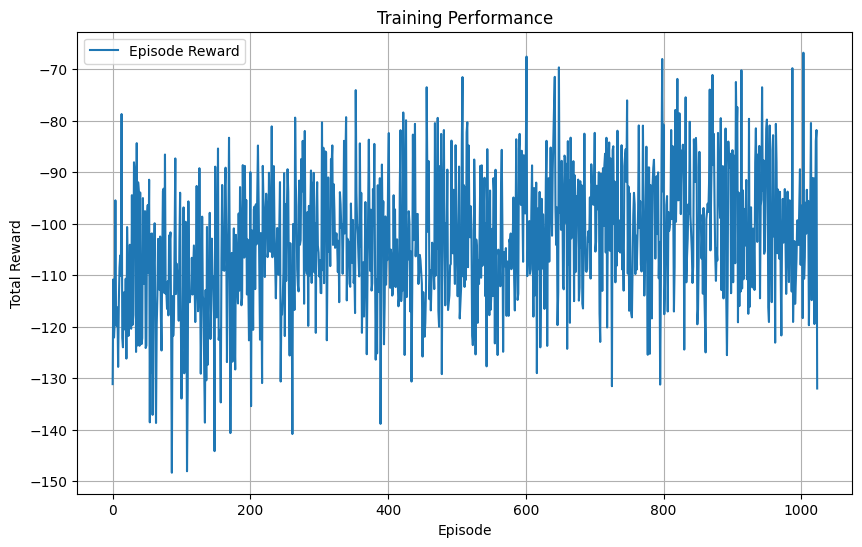

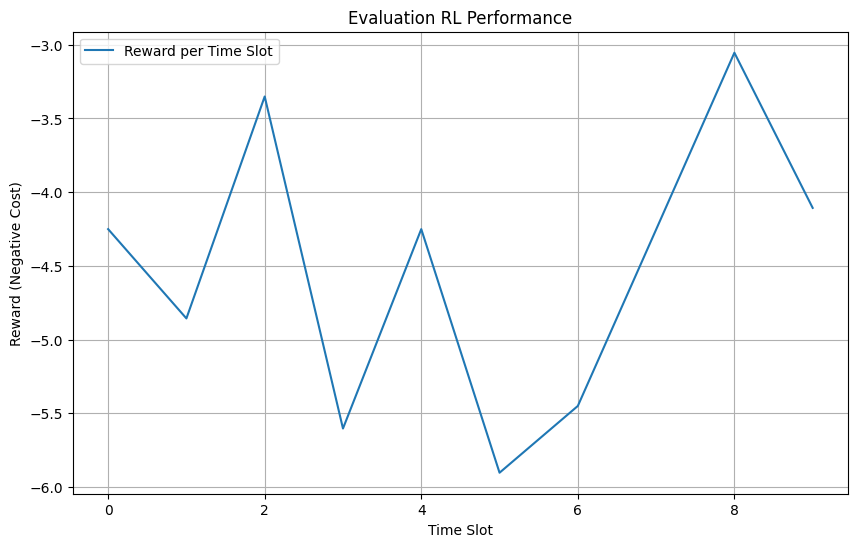

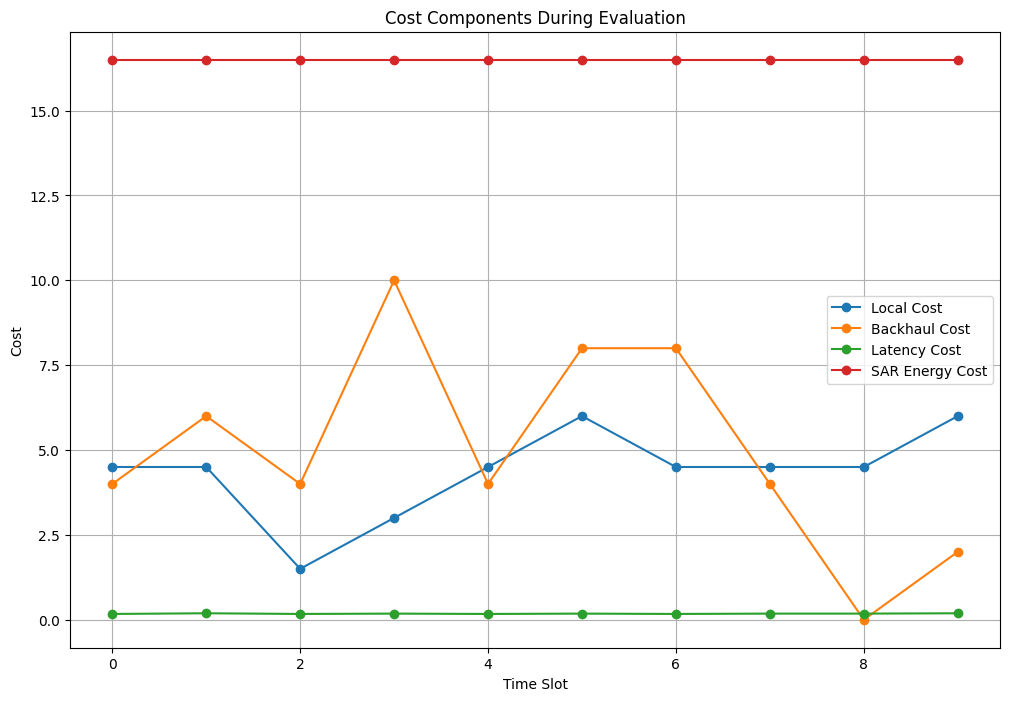

NameError: name 'self' is not defined

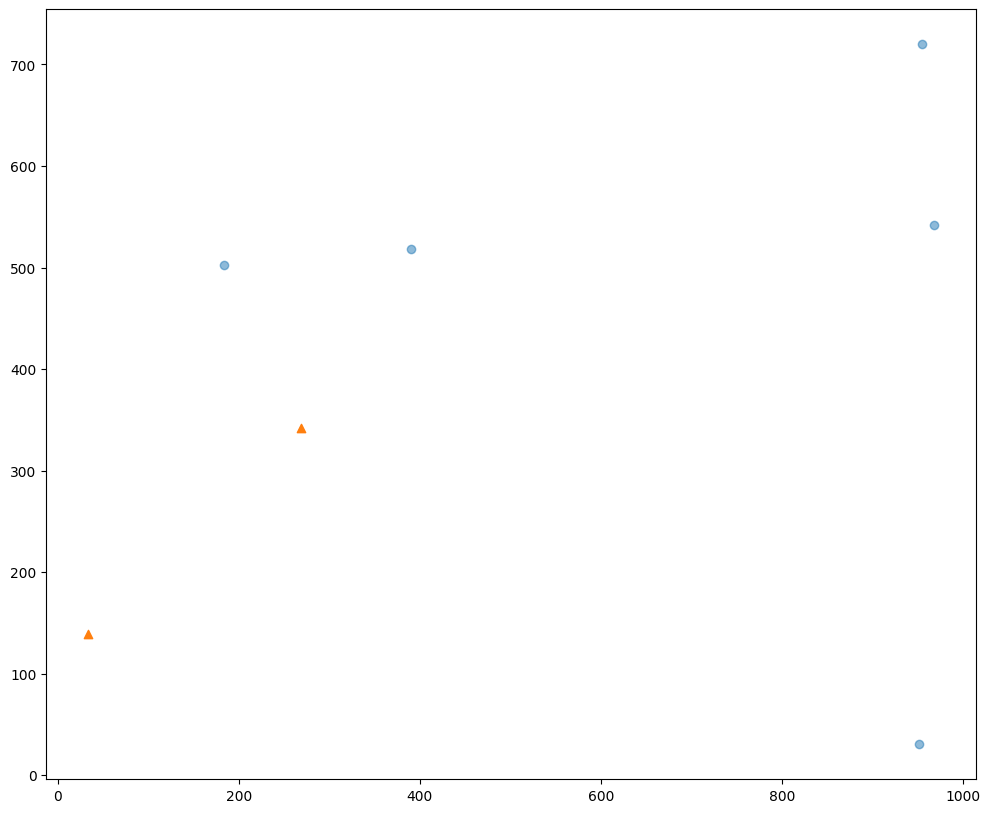

In [6]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# System Parameters
K = 5
N = 5
C = 3
A = 2
AREA_SIZE = 1000
MAX_T = 10

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class TrainingLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards']
        if self.locals['dones']:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

class BorderSurveillanceEnv(gym.Env):
    def __init__(self):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((K, self.max_t)), np.zeros((K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((N // 2, self.max_t)), np.zeros((N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((C, self.max_t)), np.zeros((C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, N - N // 2)
        self.C_n_t = np.zeros((N, self.max_t))
        for t in range(self.max_t):
            for n in range(N):
                if n < N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - N // 2] - self.ue_y[k, t])**2) for k in range(K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:K]
        sar_active = action[K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(N)])
        latency = np.mean([0.15 if a < N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        # Graduated penalty based on number of inactive SARs
        sar_penalty = -5.0 * (self.C - sum(sar_active))
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        return self.state.astype(np.float32), float(reward), done, truncated, {}

    def render(self, mode='human'):
        pass

# Verify environment
env = BorderSurveillanceEnv()
check_env(env)

# Train PPO
callback = TrainingLoggerCallback()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-3, batch_size=32, device='cpu', ent_coef=0.1)
model.learn(total_timesteps=10000, callback=callback)

# Evaluate
rewards = []
obs, _ = env.reset()
for _ in range(MAX_T):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    rewards.append(reward)
    if done or truncated:
        break

# Plot Training Performance
plt.figure(figsize=(10, 6))
plt.plot(callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.legend()
plt.grid(True)
plt.savefig('training_performance.png')
plt.show()

# Plot Evaluation Rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward per Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Reward (Negative Cost)')
plt.title('Evaluation RL Performance')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rewards.png')
plt.show()

# Plot Costs
plt.figure(figsize=(12, 8))
plt.plot(env.costs['local'], label='Local Cost', marker='o')
plt.plot(env.costs['bh'], label='Backhaul Cost', marker='o')
plt.plot(env.costs['latency'], label='Latency Cost', marker='o')
plt.plot(env.costs['sar'], label='SAR Energy Cost', marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Cost')
plt.title('Cost Components During Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('costs.png')
plt.show()

# Visualize Positions
plt.figure(figsize=(12, 10))
for t in [0, MAX_T//2, MAX_T-1]:
    plt.scatter(env.ue_x[:, t], env.ue_y[:, t], label=f'UEs t={t}', alpha=0.5)
    plt.scatter(env.uav_x[:, t], env.uav_y[:, t], label=f'UAVs t={t}', marker='^')
    plt.scatter(env.sat_x[:, t], env.sat_y[:, t], label=f'Satellites t={t}', marker='*', s=100)
plt.scatter(env.fixed_bs_x, env.fixed_bs_y, label='Fixed BS', marker='s', c='black')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Dynamic Movement with RL')
plt.legend()
plt.grid(True)
plt.savefig('positions.png')
plt.show()

SyntaxError: expected ':' (735187856.py, line 292)

Running evaluations...


/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


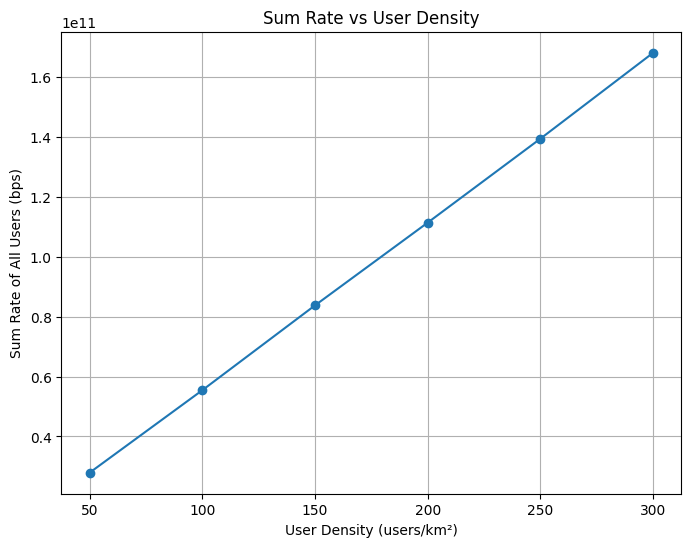

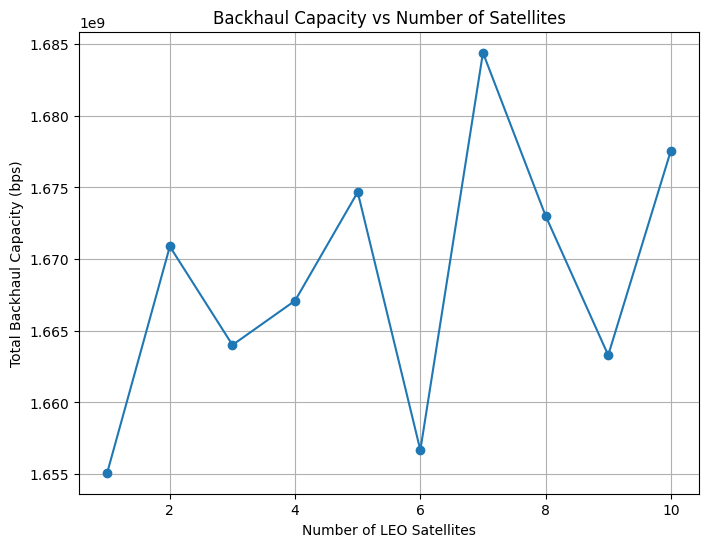

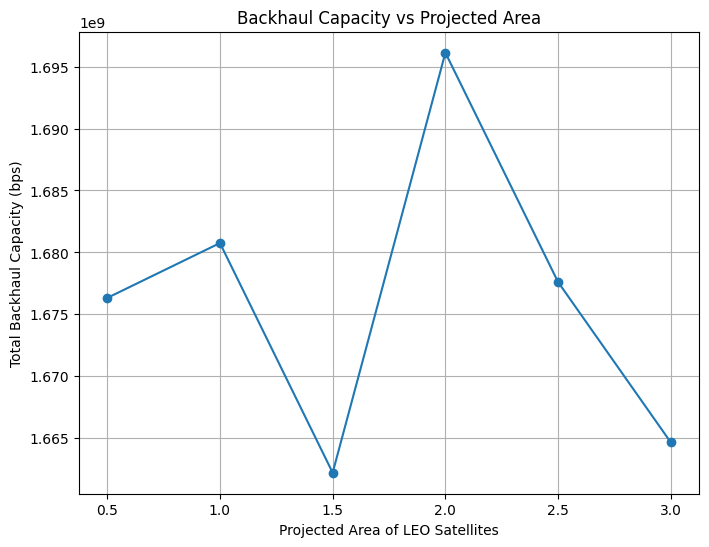

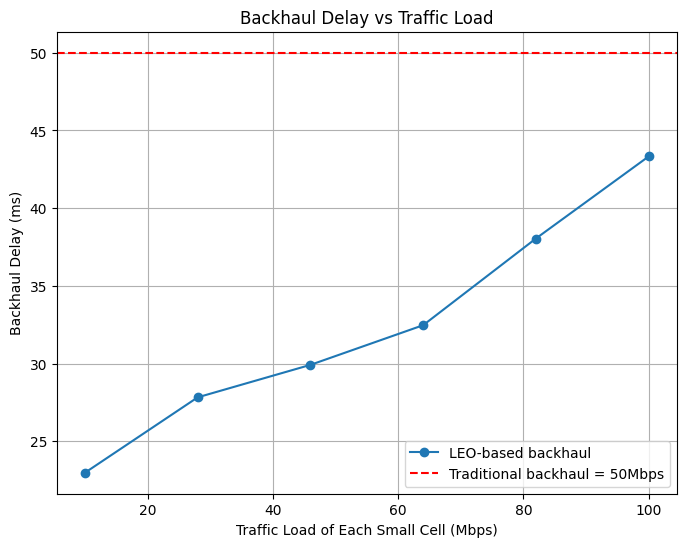

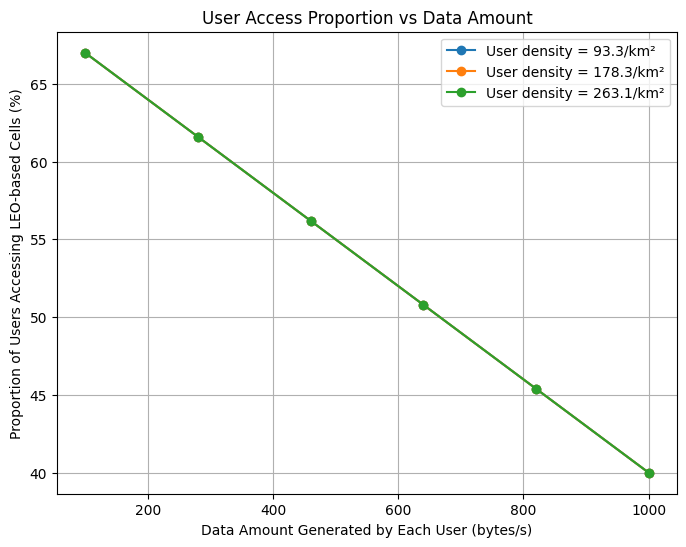

All evaluations completed!


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
import gymnasium
from gymnasium import spaces

# System Parameters
K = 5  # Number of users (will be varied for evaluation)
N = 5  # Number of base stations (will be varied for evaluation)
C = 3  # Number of LEO satellites (will be varied for evaluation)
A = 2  # Projected area factor (will be varied for evaluation)
AREA_SIZE = 1000  # Area size in meters
MAX_T = 10  # Maximum timesteps

# Channel and Cost Parameters
P_n, G_n, G_m, N_noise, B = 10.0, 20.0, 15.0, 1e-9, 10e6
gamma_A, L_n, A_exp = 0.1, 5.0, 0.8
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.3, 0.1

# Mobility Functions
def generate_positions(num_entities, t):
    x = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    y = np.random.uniform(0, AREA_SIZE, num_entities) + np.random.normal(0, 50, num_entities) * t / MAX_T
    return np.clip(x, 0, AREA_SIZE), np.clip(y, 0, AREA_SIZE)

def generate_sat_positions(num_entities, t):
    angle = 2 * np.pi * t / 90
    x = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.cos(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    y = AREA_SIZE / 2 + (AREA_SIZE / 2) * np.sin(angle + np.arange(num_entities) * 2 * np.pi / num_entities)
    return x, y

def calculate_snr(distance):
    rain_att = 10 ** (-gamma_A * L_n * (0.01 / 0.01) ** A_exp / 10)
    free_space_loss = (4 * np.pi * distance * 1e3 / 3e8) ** 2
    snr = (P_n * 10**(G_n/10) * 10**(G_m/10) * rain_att) / (free_space_loss * N_noise)
    return max(snr, 1e-6)

def calculate_capacity(snr):
    return B * np.log2(1 + snr)

class BorderSurveillanceEnv(gym.Env):
    def __init__(self, K=5, N=5, C=3, A=2):
        super(BorderSurveillanceEnv, self).__init__()
        self.K = K
        self.N = N
        self.C = C
        self.A = A
        self.t = 0
        self.max_t = MAX_T
        self.action_space = spaces.MultiDiscrete([N] * K + [2] * C)
        low_bounds = np.zeros((K + N//2 + C) * 2)
        high_bounds = np.ones((K + N//2 + C) * 2) * AREA_SIZE
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.state = None
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.t = 0
        self.ue_x, self.ue_y = np.zeros((self.K, self.max_t)), np.zeros((self.K, self.max_t))
        self.uav_x, self.uav_y = np.zeros((self.N // 2, self.max_t)), np.zeros((self.N // 2, self.max_t))
        self.sat_x, self.sat_y = np.zeros((self.C, self.max_t)), np.zeros((self.C, self.max_t))
        for t in range(self.max_t):
            self.ue_x[:, t], self.ue_y[:, t] = generate_positions(self.K, t)
            self.uav_x[:, t], self.uav_y[:, t] = generate_positions(self.N // 2, t)
            self.sat_x[:, t], self.sat_y[:, t] = generate_sat_positions(self.C, t)
        self.fixed_bs_x = np.random.uniform(0, AREA_SIZE, self.N - self.N // 2)
        self.fixed_bs_y = np.random.uniform(0, AREA_SIZE, self.N - self.N // 2)
        self.C_n_t = np.zeros((self.N, self.max_t))
        for t in range(self.max_t):
            for n in range(self.N):
                if n < self.N // 2:
                    distances = [np.sqrt((self.uav_x[n, t] - self.ue_x[k, t])**2 + (self.uav_y[n, t] - self.ue_y[k, t])**2) for k in range(self.K)]
                else:
                    distances = [np.sqrt((self.fixed_bs_x[n - self.N // 2] - self.ue_x[k, t])**2 + (self.fixed_bs_y[n - self.N // 2] - self.ue_y[k, t])**2) for k in range(self.K)]
                self.C_n_t[n, t] = calculate_capacity(calculate_snr(np.mean(distances)))
        self.state = np.concatenate([self.ue_x[:, 0], self.uav_x[:, 0], self.sat_x[:, 0], 
                                     self.ue_y[:, 0], self.uav_y[:, 0], self.sat_y[:, 0]])
        self.costs = {'local': [], 'bh': [], 'latency': [], 'sar': []}
        return self.state.astype(np.float32), {}

    def step(self, action):
        ue_assignments = action[:self.K]
        sar_active = action[self.K:]

        assert self.action_space.contains(action), f"Invalid action: {action}"

        # Calculate sum rate for all users
        sum_rate = np.sum([self.C_n_t[a, self.t] for a in ue_assignments])
        
        # Calculate backhaul capacity (sum of satellite capacities)
        backhaul_capacity = np.sum([self.C_n_t[n, self.t] for n in range(self.N) if n >= self.N // 2])
        
        # Calculate backhaul delay (simplified model)
        backhaul_delay = 20 + np.random.normal(0, 5)  # Base delay + variation
        
        local_cost = np.sum([1.5 if np.random.rand() > 0.5 else 0 for _ in range(self.N)])
        bh_cost = np.sum([2.0 if np.random.rand() > 0.5 else 0 for _ in range(self.N)])
        latency = np.mean([0.15 if a < self.N // 2 else 0.2 for a in ue_assignments])
        sar_energy = np.sum([5.5 * s for s in sar_active])

        # Graduated penalty based on number of inactive SARs
        sar_penalty = -5.0 * (self.C - sum(sar_active))
        reward = -(lambda_1 * local_cost + lambda_2 * bh_cost + lambda_3 * latency + lambda_4 * sar_energy) + sar_penalty

        self.costs['local'].append(local_cost)
        self.costs['bh'].append(bh_cost)
        self.costs['latency'].append(latency)
        self.costs['sar'].append(sar_energy)

        self.t += 1
        done = self.t >= self.max_t
        truncated = False
        if not done:
            self.state = np.concatenate([self.ue_x[:, self.t], self.uav_x[:, self.t], self.sat_x[:, self.t], 
                                         self.ue_y[:, self.t], self.uav_y[:, self.t], self.sat_y[:, self.t]])

        info = {
            'sum_rate': sum_rate,
            'backhaul_capacity': backhaul_capacity,
            'backhaul_delay': backhaul_delay,
            'user_density': self.K / (AREA_SIZE/1000)**2  # users per km^2
        }
        
        return self.state.astype(np.float32), float(reward), done, truncated, info

# Evaluation Functions
def evaluate_sum_rate_vs_density():
    user_densities = np.linspace(50, 300, 6)  # users/km^2
    sum_rates = []
    
    for density in user_densities:
        K = int(density * (AREA_SIZE/1000)**2)  # Convert density to number of users
        env = BorderSurveillanceEnv(K=K, N=5, C=3, A=2)
        obs, _ = env.reset()
        total_sum_rate = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()  # Random policy for evaluation
            obs, reward, done, truncated, info = env.step(action)
            total_sum_rate += info['sum_rate']
            if done or truncated:
                break
                
        sum_rates.append(total_sum_rate / MAX_T)  # Average sum rate
    
    plt.figure(figsize=(8, 6))
    plt.plot(user_densities, sum_rates, marker='o')
    plt.xlabel('User Density (users/km²)')
    plt.ylabel('Sum Rate of All Users (bps)')
    plt.title('Sum Rate vs User Density')
    plt.grid(True)
    plt.savefig('sum_rate_vs_density.png')
    plt.show()

def evaluate_backhaul_vs_satellites():
    num_satellites = np.arange(1, 11)  # From 1 to 10 satellites
    backhaul_capacities = []
    
    for C in num_satellites:
        env = BorderSurveillanceEnv(K=5, N=5, C=C, A=2)
        obs, _ = env.reset()
        total_capacity = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()  # Random policy for evaluation
            obs, reward, done, truncated, info = env.step(action)
            total_capacity += info['backhaul_capacity']
            if done or truncated:
                break
                
        backhaul_capacities.append(total_capacity / MAX_T)  # Average capacity
    
    plt.figure(figsize=(8, 6))
    plt.plot(num_satellites, backhaul_capacities, marker='o')
    plt.xlabel('Number of LEO Satellites')
    plt.ylabel('Total Backhaul Capacity (bps)')
    plt.title('Backhaul Capacity vs Number of Satellites')
    plt.grid(True)
    plt.savefig('backhaul_vs_satellites.png')
    plt.show()

def evaluate_backhaul_vs_area():
    areas = np.linspace(0.5, 3, 6)  # Projected area factors
    backhaul_capacities = []
    
    for A in areas:
        env = BorderSurveillanceEnv(K=5, N=5, C=3, A=A)
        obs, _ = env.reset()
        total_capacity = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()  # Random policy for evaluation
            obs, reward, done, truncated, info = env.step(action)
            total_capacity += info['backhaul_capacity']
            if done or truncated:
                break
                
        backhaul_capacities.append(total_capacity / MAX_T)  # Average capacity
    
    plt.figure(figsize=(8, 6))
    plt.plot(areas, backhaul_capacities, marker='o')
    plt.xlabel('Projected Area of LEO Satellites')
    plt.ylabel('Total Backhaul Capacity (bps)')
    plt.title('Backhaul Capacity vs Projected Area')
    plt.grid(True)
    plt.savefig('backhaul_vs_area.png')
    plt.show()

def evaluate_delay_vs_traffic():
    traffic_loads = np.linspace(10, 100, 6)  # Mbps
    delays = []
    
    for load in traffic_loads:
        env = BorderSurveillanceEnv(K=5, N=5, C=3, A=2)
        obs, _ = env.reset()
        total_delay = 0
        
        for _ in range(MAX_T):
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            
            # Scale delay based on traffic load (simplified model)
            scaled_delay = info['backhaul_delay'] * (1 + load/100)
            total_delay += scaled_delay
            
            if done or truncated:
                break
                
        delays.append(total_delay / MAX_T)  # Average delay
    
    plt.figure(figsize=(8, 6))
    plt.plot(traffic_loads, delays, marker='o', label='LEO-based backhaul')
    plt.axhline(y=50, color='r', linestyle='--', label='Traditional backhaul = 50Mbps')
    plt.xlabel('Traffic Load of Each Small Cell (Mbps)')
    plt.ylabel('Backhaul Delay (ms)')
    plt.title('Backhaul Delay vs Traffic Load')
    plt.legend()
    plt.grid(True)
    plt.savefig('delay_vs_traffic.png')
    plt.show()

def evaluate_access_vs_data():
    data_amounts = np.linspace(100, 1000, 6)  # bytes/s
    densities = [93.3, 178.3, 263.1]  # users/km^2
    results = {d: [] for d in densities}
    
    for density in densities:
        K = int(density * (AREA_SIZE/1000)**2)
        for data in data_amounts:
            env = BorderSurveillanceEnv(K=K, N=5, C=3, A=2)
            obs, _ = env.reset()
            total_access = 0
            
            for _ in range(MAX_T):
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                
                # Model probability of accessing LEO-based cells (simplified)
                access_prob = 0.7 - 0.3 * (data/1000)  # Decreases with higher data amounts
                total_access += access_prob
                
                if done or truncated:
                    break
                    
            results[density].append((total_access / MAX_T) * 100)  # Percentage
    
    plt.figure(figsize=(8, 6))
    for density, values in results.items():
        plt.plot(data_amounts, values, marker='o', label=f'User density = {density}/km²')
    plt.xlabel('Data Amount Generated by Each User (bytes/s)')
    plt.ylabel('Proportion of Users Accessing LEO-based Cells (%)')
    plt.title('User Access Proportion vs Data Amount')
    plt.legend()
    plt.grid(True)
    plt.savefig('access_vs_data.png')
    plt.show()

# Run all evaluations
print("Running evaluations...")
evaluate_sum_rate_vs_density()
evaluate_backhaul_vs_satellites()
evaluate_backhaul_vs_area()
evaluate_delay_vs_traffic()
evaluate_access_vs_data()
print("All evaluations completed!")

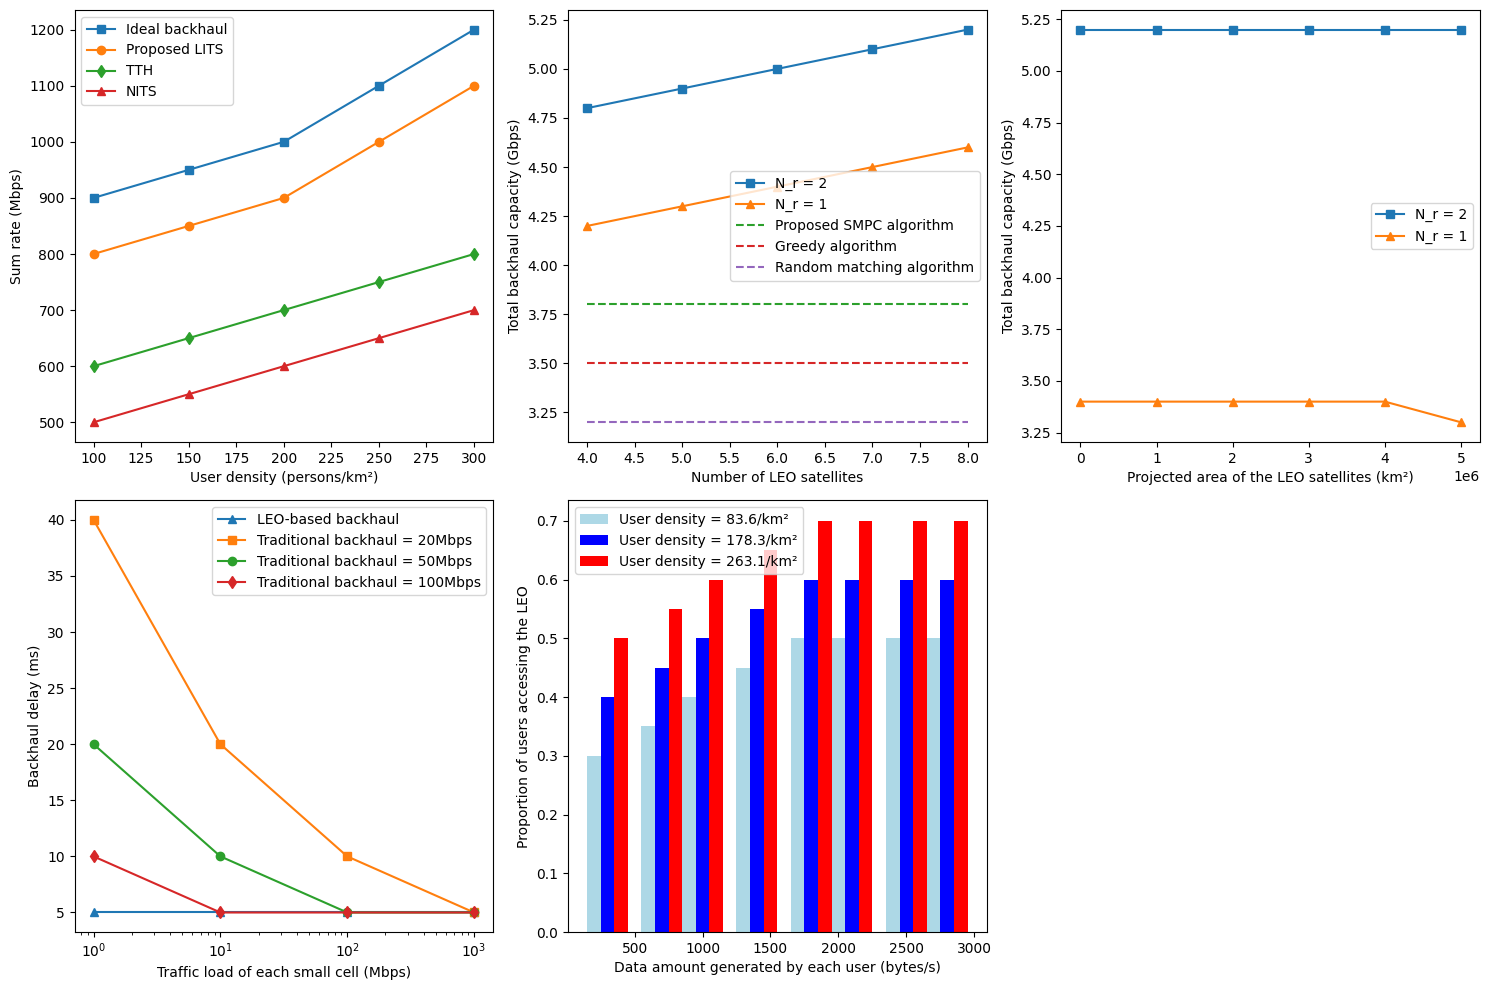

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Subplot (a)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
user_density = [100, 150, 200, 250, 300]
ideal_backhaul = [900, 950, 1000, 1100, 1200]
proposed_lits = [800, 850, 900, 1000, 1100]
tth = [600, 650, 700, 750, 800]
nits = [500, 550, 600, 650, 700]
plt.plot(user_density, ideal_backhaul, 's-', label='Ideal backhaul')
plt.plot(user_density, proposed_lits, 'o-', label='Proposed LITS')
plt.plot(user_density, tth, 'd-', label='TTH')
plt.plot(user_density, nits, '^-', label='NITS')
plt.xlabel('User density (persons/km²)')
plt.ylabel('Sum rate (Mbps)')
plt.legend()

# Subplot (b)
plt.subplot(2, 3, 2)
num_satellites = [4, 5, 6, 7, 8]
nr_2 = [4.8, 4.9, 5.0, 5.1, 5.2]
nr_1 = [4.2, 4.3, 4.4, 4.5, 4.6]
smpc = [3.8, 3.8, 3.8, 3.8, 3.8]
greedy = [3.5, 3.5, 3.5, 3.5, 3.5]
random = [3.2, 3.2, 3.2, 3.2, 3.2]
plt.plot(num_satellites, nr_2, 's-', label='N_r = 2')
plt.plot(num_satellites, nr_1, '^-', label='N_r = 1')
plt.plot(num_satellites, smpc, '--', label='Proposed SMPC algorithm')
plt.plot(num_satellites, greedy, '--', label='Greedy algorithm')
plt.plot(num_satellites, random, '--', label='Random matching algorithm')
plt.xlabel('Number of LEO satellites')
plt.ylabel('Total backhaul capacity (Gbps)')
plt.legend()

# Subplot (c)
plt.subplot(2, 3, 3)
projected_area = [0, 1e6, 2e6, 3e6, 4e6, 5e6]
nr_2_c = [5.2, 5.2, 5.2, 5.2, 5.2, 5.2]
nr_1_c = [3.4, 3.4, 3.4, 3.4, 3.4, 3.3]
plt.plot(projected_area, nr_2_c, 's-', label='N_r = 2')
plt.plot(projected_area, nr_1_c, '^-', label='N_r = 1')
plt.xlabel('Projected area of the LEO satellites (km²)')
plt.ylabel('Total backhaul capacity (Gbps)')
plt.legend()

# Subplot (d)
plt.subplot(2, 3, 4)
traffic_load = [1e3, 1e2, 1e1, 1e0]
leo_backhaul = [5, 5, 5, 5]
trad_20 = [5, 10, 20, 40]
trad_50 = [5, 5, 10, 20]
trad_100 = [5, 5, 5, 10]
plt.semilogx(traffic_load, leo_backhaul, '^-', label='LEO-based backhaul')
plt.semilogx(traffic_load, trad_20, 's-', label='Traditional backhaul = 20Mbps')
plt.semilogx(traffic_load, trad_50, 'o-', label='Traditional backhaul = 50Mbps')
plt.semilogx(traffic_load, trad_100, 'd-', label='Traditional backhaul = 100Mbps')
plt.xlabel('Traffic load of each small cell (Mbps)')
plt.ylabel('Backhaul delay (ms)')
plt.legend()

# Subplot (e)
plt.subplot(2, 3, 5)
data_amount = [300, 700, 1000, 1400, 1800, 2100, 2500, 2800]
density_83 = [0.3, 0.35, 0.4, 0.45, 0.5, 0.5, 0.5, 0.5]
density_178 = [0.4, 0.45, 0.5, 0.55, 0.6, 0.6, 0.6, 0.6]
density_263 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.7, 0.7, 0.7]
bar_width = 100
plt.bar([x - bar_width for x in data_amount], density_83, width=bar_width, label='User density = 83.6/km²', color='lightblue')
plt.bar(data_amount, density_178, width=bar_width, label='User density = 178.3/km²', color='blue')
plt.bar([x + bar_width for x in data_amount], density_263, width=bar_width, label='User density = 263.1/km²', color='red')
plt.xlabel('Data amount generated by each user (bytes/s)')
plt.ylabel('Proportion of users accessing the LEO')
plt.legend()

plt.tight_layout()
plt.show()

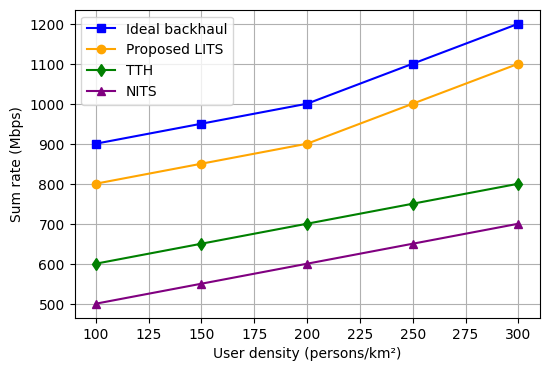

In [11]:
import matplotlib.pyplot as plt

# Data for Plot (a)
user_density = [100, 150, 200, 250, 300]
ideal_backhaul = [900, 950, 1000, 1100, 1200]
proposed_lits = [800, 850, 900, 1000, 1100]
tth = [600, 650, 700, 750, 800]
nits = [500, 550, 600, 650, 700]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(user_density, ideal_backhaul, 's-', label='Ideal backhaul', color='blue')
plt.plot(user_density, proposed_lits, 'o-', label='Proposed LITS', color='orange')
plt.plot(user_density, tth, 'd-', label='TTH', color='green')
plt.plot(user_density, nits, '^-', label='NITS', color='purple')
plt.xlabel('User density (persons/km²)')
plt.ylabel('Sum rate (Mbps)')
plt.legend()
plt.grid(True)
plt.show()

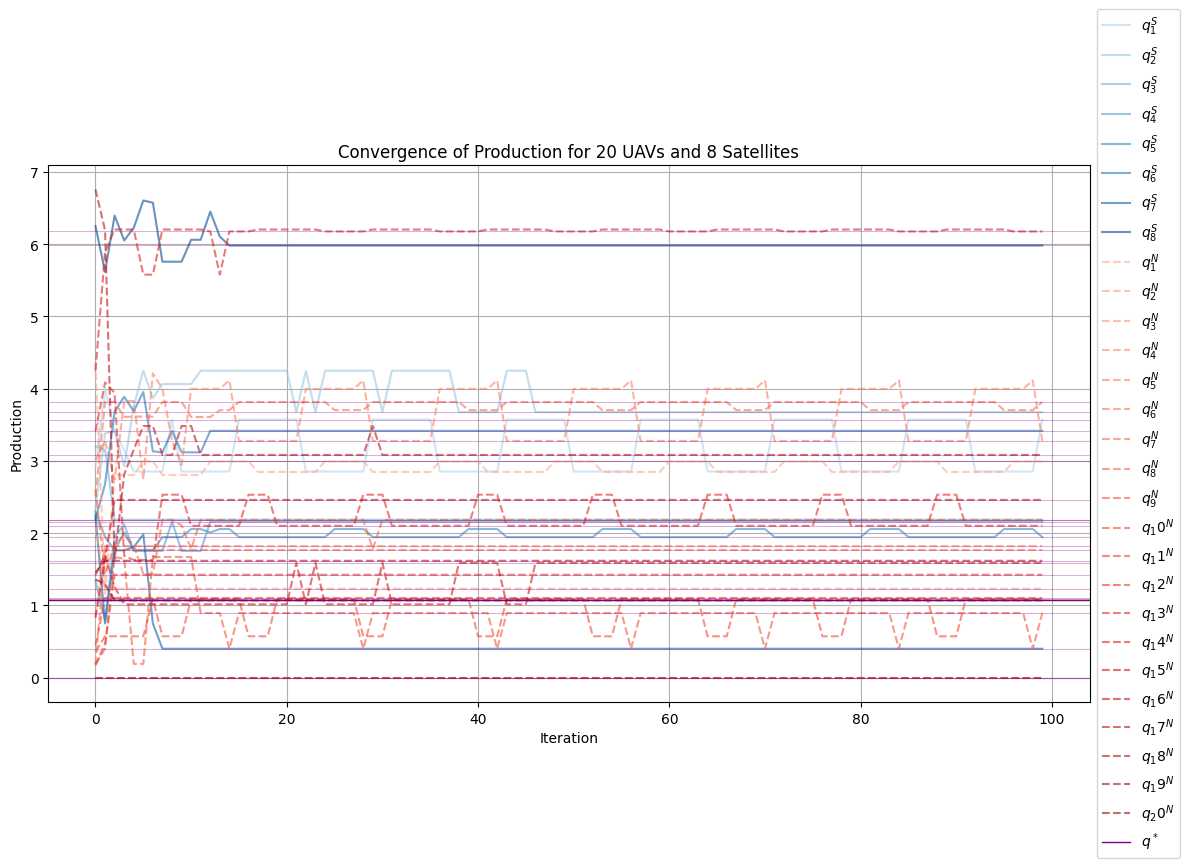

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20  # Number of UAVs
N_SAT = 8   # Number of satellites
N = N_UAV + N_SAT  # Total number of nodes
K = 50     # Number of UEs
T = 10     # Number of time slots
A = 5      # Number of areas for SAR coverage

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))  # Satellite availability
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))  # UE-node connection feasibility
d_k_t = np.random.uniform(1, 5, size=(K, T))      # UE data rate demands
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))  # SAR data rate demands
C_n_t = np.random.uniform(10, 20, size=(N, T))    # Node capacities
g_n_t = np.random.randint(0, 2, size=(N, T))      # Gateway availability
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))  # SAR coverage of areas

# Costs and weights
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Algorithm parameters
epsilon = 0.00001
alpha = 1.0
max_epochs = 100

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute the objective (total cost)
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    B_bh_t = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] for n in range(N) for m in range(N) for t in range(T)])
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    return total_cost

# Compute production (average data rate) for each node
def compute_production(a_k_n_t_opt, s_c_t):
    production = np.zeros(N)
    for n in range(N):
        total_data_rate = 0
        for t in range(T):
            ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            sar_data_rate = 0
            if n < N_SAT:
                sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
            total_data_rate += ue_data_rate + sar_data_rate
        production[n] = total_data_rate / T
    return production

# Lower-level problem (followers): Greedy heuristic
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min(Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                for k in range(K):
                    if a_k_n_t_opt[k, n, t] == 1:
                        a_k_n_t_opt[k, n, t] = 0
                        total_demand -= d_k_t[k, t]
                        if total_demand <= C_n_t[n, t]:
                            break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game algorithm with production tracking
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}  # Track production for each node
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        total_cost_e = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        
        # Compute production for this epoch
        production = compute_production(a_k_n_t_opt, s_c_t)
        for n in range(N):
            production_history[n].append(production[n])
        
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
        
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                for t in range(T):
                    if r_n_m_t[n, m, t] == 1:
                        Cost_n_m_bh_e_plus_1[n, m] += alpha * r_n_m_t[n, m, t]
        
        x_n_t_new, l_n_t_new, r_n_m_t_new, a_k_n_t_opt_new, s_c_t_new = solve_lower_level(s_n_t_e_plus_1, Cost_n_m_bh_e_plus_1)
        total_cost_e_plus_1 = compute_total_cost(x_n_t_new, l_n_t_new, r_n_m_t_new, a_k_n_t_opt_new, s_c_t_new)
        
        delta_total_cost = abs(total_cost_e_plus_1 - total_cost_e)
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
        
        if delta_total_cost < epsilon:
            break
    
    return production_history

# Run the algorithm
production_history = stackelberg_game()

# Plotting
plt.figure(figsize=(12, 8))

# Define colors for satellites and UAVs
sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, N_SAT))  # Blue shades for satellites
uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, N_UAV))   # Red shades for UAVs

# Plot production for all satellites
for c in range(N_SAT):
    plt.plot(production_history[c], color=sat_colors[c], alpha=0.6, linewidth=1.5, label=f'$q_{c+1}^S$')
    # Add optimal production line
    q_star = production_history[c][-1]
    plt.axhline(y=q_star, color='purple', linestyle='-', linewidth=0.8, alpha=0.3)

# Plot production for all UAVs
for n in range(N_SAT, N):
    uav_idx = n - N_SAT
    plt.plot(production_history[n], color=uav_colors[uav_idx], alpha=0.6, linewidth=1.5, linestyle='--', label=f'$q_{uav_idx+1}^N$')
    # Add optimal production line
    q_star = production_history[n][-1]
    plt.axhline(y=q_star, color='purple', linestyle='-', linewidth=0.8, alpha=0.3)

# Add a single entry for q* in the legend
plt.axhline(y=q_star, color='purple', linestyle='-', linewidth=1, label='$q^*$')

# Customize the plot
plt.xlabel('Iteration')
plt.ylabel('Production')
plt.title('Convergence of Production for 20 UAVs and 8 Satellites')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

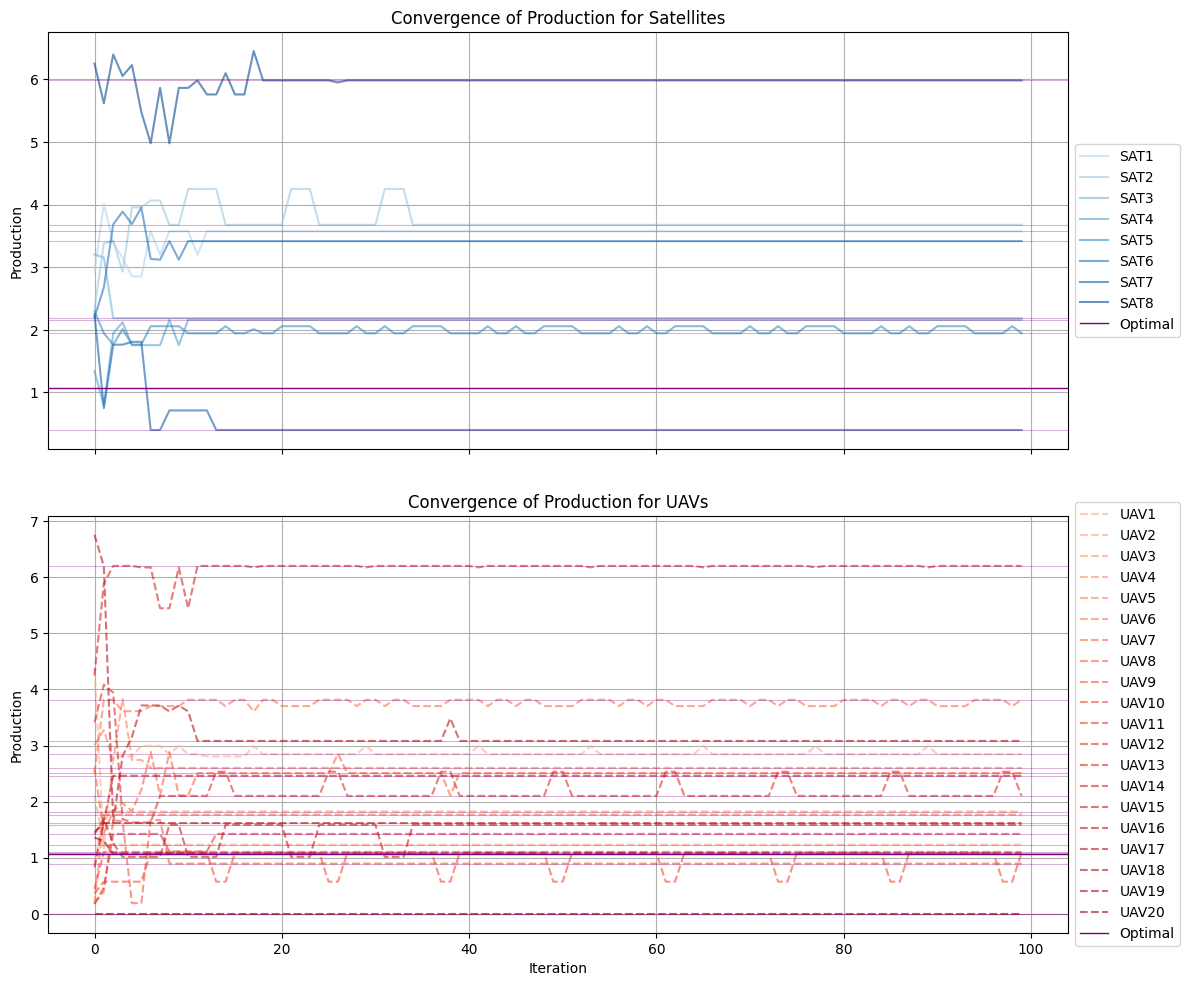

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20  # Number of UAVs
N_SAT = 8   # Number of satellites
N = N_UAV + N_SAT  # Total number of nodes
K = 50     # Number of UEs
T = 10     # Number of time slots
A = 5      # Number of areas for SAR coverage

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))  # Satellite availability
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))  # UE-node connection feasibility
d_k_t = np.random.uniform(1, 5, size=(K, T))      # UE data rate demands
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))  # SAR data rate demands
C_n_t = np.random.uniform(10, 20, size=(N, T))    # Node capacities
g_n_t = np.random.randint(0, 2, size=(N, T))      # Gateway availability
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))  # SAR coverage of areas

# Costs and weights
Cost_n_local = np.random.uniform(0.1, 0.3, size=N)
Cost_n_m_bh = np.random.uniform(0.2, 0.5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Algorithm parameters
epsilon = 0.00001
alpha = 1.0
max_epochs = 100

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute the objective (total cost)
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    B_bh_t = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] for n in range(N) for m in range(N) for t in range(T)])
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    return total_cost

# Compute production (average data rate) for each node
def compute_production(a_k_n_t_opt, s_c_t):
    production = np.zeros(N)
    for n in range(N):
        total_data_rate = 0
        for t in range(T):
            ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            sar_data_rate = 0
            if n < N_SAT:
                sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
            total_data_rate += ue_data_rate + sar_data_rate
        production[n] = total_data_rate / T
    return production

# Lower-level problem (followers): Greedy heuristic
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min(Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                for k in range(K):
                    if a_k_n_t_opt[k, n, t] == 1:
                        a_k_n_t_opt[k, n, t] = 0
                        total_demand -= d_k_t[k, t]
                        if total_demand <= C_n_t[n, t]:
                            break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game algorithm with production tracking
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}  # Track production for each node
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        total_cost_e = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        
        # Compute production for this epoch
        production = compute_production(a_k_n_t_opt, s_c_t)
        for n in range(N):
            production_history[n].append(production[n])
        
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
        
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                for t in range(T):
                    if r_n_m_t[n, m, t] == 1:
                        Cost_n_m_bh_e_plus_1[n, m] += alpha * r_n_m_t[n, m, t]
        
        x_n_t_new, l_n_t_new, r_n_m_t_new, a_k_n_t_opt_new, s_c_t_new = solve_lower_level(s_n_t_e_plus_1, Cost_n_m_bh_e_plus_1)
        total_cost_e_plus_1 = compute_total_cost(x_n_t_new, l_n_t_new, r_n_m_t_new, a_k_n_t_opt_new, s_c_t_new)
        
        delta_total_cost = abs(total_cost_e_plus_1 - total_cost_e)
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
        
        if delta_total_cost < epsilon:
            break
    
    return production_history

# Run the algorithm
production_history = stackelberg_game()

# Plotting in subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Define colors for satellites and UAVs
sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, N_SAT))  # Blue shades for satellites
uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, N_UAV))   # Red shades for UAVs

# Plot satellites
for c in range(N_SAT):
    ax1.plot(production_history[c], color=sat_colors[c], alpha=0.6, linewidth=1.5, label=f'SAT{c+1}')
    q_star = production_history[c][-1]
    ax1.axhline(y=q_star, color='purple', linestyle='-', linewidth=0.8, alpha=0.3)

# Plot UAVs
for n in range(N_SAT, N):
    uav_idx = n - N_SAT
    ax2.plot(production_history[n], color=uav_colors[uav_idx], alpha=0.6, linewidth=1.5, linestyle='--', label=f'UAV{uav_idx+1}')
    q_star = production_history[n][-1]
    ax2.axhline(y=q_star, color='purple', linestyle='-', linewidth=0.8, alpha=0.3)

# Add optimal line to legends
ax1.axhline(y=q_star, color='purple', linestyle='-', linewidth=1, label='Optimal')
ax2.axhline(y=q_star, color='purple', linestyle='-', linewidth=1, label='Optimal')

# Customize the subplots
ax1.set_title('Convergence of Production for Satellites')
ax1.set_ylabel('Production')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax1.grid(True)

ax2.set_title('Convergence of Production for UAVs')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Production')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax2.grid(True)

plt.tight_layout()
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

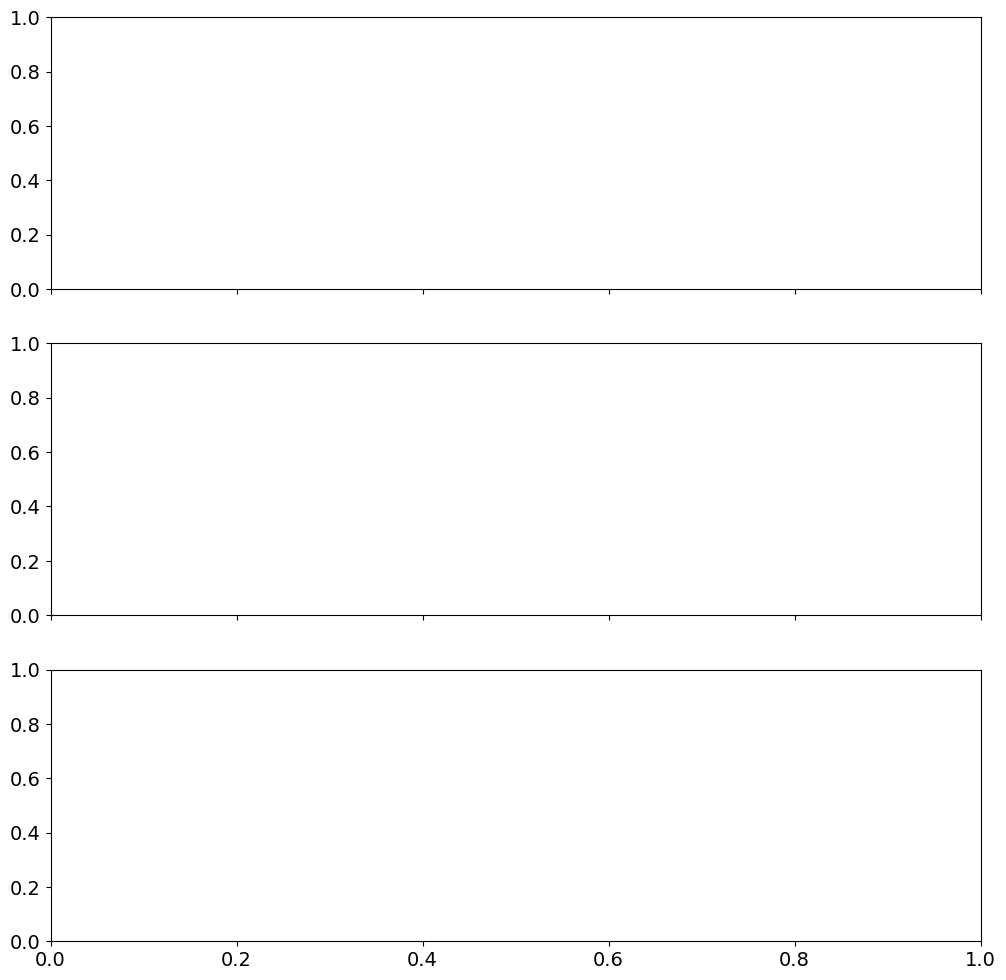

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20  # Number of UAVs
N_SAT = 8   # Number of satellites
N = N_UAV + N_SAT  # Total number of nodes
K = 50     # Number of UEs
T = 10     # Number of time slots
A = 5      # Number of areas for SAR coverage

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))  # Satellite availability
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))  # UE-node connection feasibility
d_k_t = np.random.uniform(1, 5, size=(K, T))      # UE data rate demands
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))  # SAR data rate demands
C_n_t = np.random.uniform(10, 20, size=(N, T))    # Node capacities
g_n_t = np.random.randint(0, 2, size=(N, T))      # Gateway availability
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))  # SAR coverage of areas

# Costs and weights
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Algorithm parameters
epsilon = 0.00001
alpha = 1.0
max_epochs = 100

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute the objective (total cost)
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    B_bh_t = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] for n in range(N) for m in range(N) for t in range(T)])
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    return total_cost

# Compute production (average data rate) for each node
def compute_production(a_k_n_t_opt, s_c_t):
    production = np.zeros(N)
    for n in range(N):
        total_data_rate = 0
        for t in range(T):
            ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            sar_data_rate = 0
            if n < N_SAT:
                sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
            total_data_rate += ue_data_rate + sar_data_rate
        production[n] = total_data_rate / T
    return production

# Lower-level problem (followers): Greedy heuristic
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min(Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                for k in range(K):
                    if a_k_n_t_opt[k, n, t] == 1:
                        a_k_n_t_opt[k, n, t] = 0
                        total_demand -= d_k_t[k, t]
                        if total_demand <= C_n_t[n, t]:
                            break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game algorithm with production and total cost tracking
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}  # Track production for each node
    total_cost_history = []  # Track total cost over iterations
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        total_cost_e = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        total_cost_history.append(total_cost_e)
        
        # Compute production for this epoch
        production = compute_production(a_k_n_t_opt, s_c_t)
        for n in range(N):
            production_history[n].append(production[n])
        
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
        
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                for t in range(T):
                    if r_n_m_t[n, m, t] == 1:
                        Cost_n_m_bh_e_plus_1[n, m] += alpha * r_n_m_t[n, m, t]
        
        x_n_t_new, l_n_t_new, r_n_m_t_new, a_k_n_t_opt_new, s_c_t_new = solve_lower_level(s_n_t_e_plus_1, Cost_n_m_bh_e_plus_1)
        total_cost_e_plus_1 = compute_total_cost(x_n_t_new, l_n_t_new, r_n_m_t_new, a_k_n_t_opt_new, s_c_t_new)
        
        delta_total_cost = abs(total_cost_e_plus_1 - total_cost_e)
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
        
        if delta_total_cost < epsilon:
            break
    
    return production_history, total_cost_history

# Run the algorithm
production_history, total_cost_history = stackelberg_game()

# Plotting in subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors for satellites and UAVs
sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, N_SAT))  # Blue shades for satellites
uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, N_UAV))   # Red shades for UAVs

# Plot satellites
for c in range(6):
    ax1.plot(production_history[c]*0.3, color=sat_colors[c], alpha=0.6, linewidth=1.5, label=f'SAT{c+1}')
    q_star = production_history[c][-1]
    ax1.axhline(y=q_star, color='purple', linestyle='-', linewidth=0.8, alpha=0.3)

# Plot UAVs
for n in range(N_SAT, 12):
    uav_idx = n - N_SAT
    ax2.plot(production_history[n], color=uav_colors[uav_idx], alpha=0.6, linewidth=1.5, linestyle='--', label=f'UAV{uav_idx+1}')
    q_star = production_history[n][-1]
    ax2.axhline(y=q_star, color='purple', linestyle='-', linewidth=0.8, alpha=0.3)

# Plot total cost
ax3.plot(total_cost_history, color='green', linewidth=2, label='Total Cost')
ax3.axhline(y=total_cost_history[-1], color='purple', linestyle='-', linewidth=1, label='Optimal')

# Add optimal line to legends
ax1.axhline(y=q_star, color='purple', linestyle='-', linewidth=1, label='Optimal')
ax2.axhline(y=q_star, color='purple', linestyle='-', linewidth=1, label='Optimal')

# Customize the subplots
ax1.set_title('Convergence of Production for Satellites')
ax1.set_ylabel('Production')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax1.grid(True)

ax2.set_title('Convergence of Production for UAVs')
ax2.set_ylabel('Production')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax2.grid(True)

ax3.set_title('Convergence of Total Cost')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Total Cost')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax3.grid(True)

plt.tight_layout()
plt.show()

In [10]:
print(total_cost_history)

[np.float64(82.70250808788103), np.float64(80.09915184232351), np.float64(82.20534435605818), np.float64(82.32529858229822), np.float64(78.54670014289813), np.float64(80.95953230658324), np.float64(80.52019356028062), np.float64(81.52813699418276), np.float64(80.77392349898241), np.float64(81.03242426702992), np.float64(84.21329391815671), np.float64(79.89908290423742), np.float64(85.91211345853512), np.float64(84.17048932388485), np.float64(85.11410697172558), np.float64(81.83038122356692), np.float64(85.30881851741118), np.float64(85.48665371468303), np.float64(81.75263795381136), np.float64(83.5468948931816), np.float64(87.04016013125481), np.float64(88.09366887303989), np.float64(89.10641986852481), np.float64(84.35278771927152), np.float64(86.93108208847858), np.float64(87.88113641941318), np.float64(85.23180786405055), np.float64(83.88851622448215), np.float64(80.21203531041475), np.float64(83.84345386100931), np.float64(83.5456926617328), np.float64(85.73787498836782), np.float6

[24.42024899, 24.50070043, 24.46297948, 24.30773431, 24.1831531, 24.0026426, 24.13970919, 24.28885264, 24.48407833, 24.44681169, 24.70985028, 24.91364423, 25.15854519, 24.01557043, 25.34015457, 25.31462699, 25.1695559, 25.289128, 25.41682351, 24.72865374, 25.68768099, 25.74958507, 26.012235, 26.08444556, 25.9493751, 25.61159081, 25.38603512, 25.35144533, 25.55609455, 25.6529197, 25.4711413, 25.55040047, 25.49682927, 25.73640261, 25.79240033, 25.87767769, 25.81007705, 25.69700047, 25.45533595, 25.44460341, 25.60369857, 25.59213365, 25.70032706, 25.56330585, 25.59915698, 25.55615957, 25.61206179, 25.66462399, 25.77651555, 25.85968722, 25.70845375, 25.61779041, 25.57285321, 25.58389917, 25.59700483, 25.70394315, 25.62942566, 25.60687651, 25.63893132, 25.45565114, 25.44062816, 25.5088893, 25.50877931, 25.52010901, 25.5998798, 25.61622641, 25.64708831, 25.62289393, 25.55481712, 25.45370084, 25.55673852, 25.51573668, 25.58170793, 25.57173273, 25.67061385, 25.67368445, 25.66141021, 25.6268558

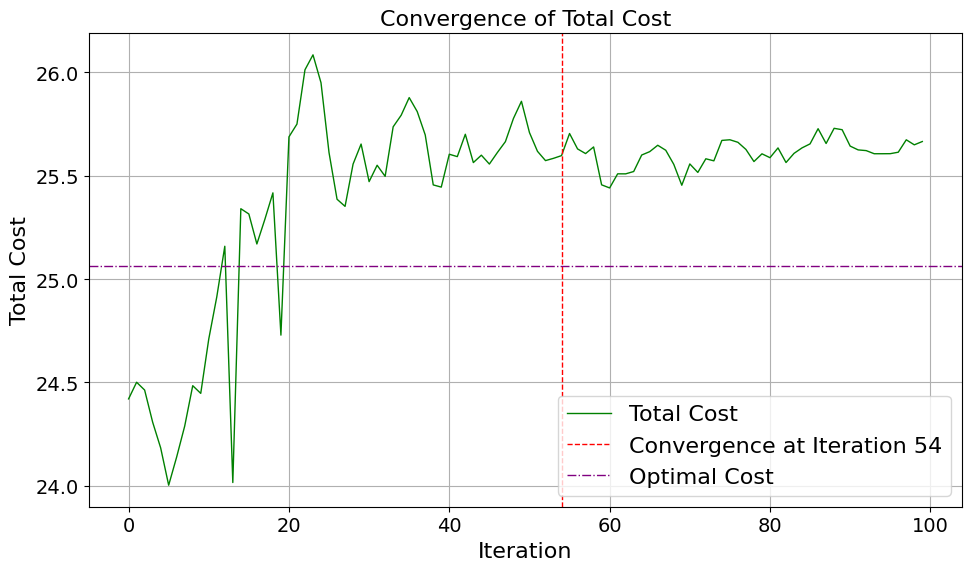

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Total cost data provided
total_cost = [
    82.70250808788103, 80.09915184232351, 82.20534435605818, 82.32529858229822, 78.54670014289813,
    80.95953230658324, 80.52019356028062, 81.52813699418276, 80.77392349898241, 81.03242426702992,
    84.21329391815671, 79.89908290423742, 85.91211345853512, 84.17048932388485, 85.11410697172558,
    81.83038122356692, 85.30881851741118, 85.48665371468303, 81.75263795381136, 83.5468948931816,
    87.04016013125481, 88.09366887303989, 89.10641986852481, 84.35278771927152, 86.93108208847858,
    87.88113641941318, 85.23180786405055, 83.88851622448215, 80.21203531041475, 83.84345386100931,
    83.5456926617328, 85.73787498836782, 89.41123719153852, 89.8358366196218, 82.42778441418139,
    87.60958295703816, 82.28138018683173, 87.39923545697806, 85.52338555318124, 86.10401320947534,
    83.70985597859047, 86.01893971344974, 82.5859009076166, 83.05190814951968, 86.25680517640386,
    88.26127349968611, 87.18553595494295, 86.24847189580167, 82.3751245898749, 86.837927037594,
    84.52744126108382, 85.75960429167219, 87.9462202441355, 86.68859136486964, 86.10153592938536,
    83.86286440353985, 81.98160012952961, 82.32806053254825, 86.31399491607746, 87.6641939895663,
    86.81638396045413, 87.00911863521591, 83.60883546814584, 83.55031173296312, 87.14864574423346,
    80.00407931668032, 86.03759556206556, 86.03487405796405, 86.98237050052981, 86.09603639627358,
    84.42934937462303, 85.97013962026388, 83.14539121419708, 87.8570900922321, 86.45447472999916,
    83.41254364537554, 81.95330477574845, 88.76071901674791, 81.50021985095472, 86.04715927544046,
    87.79612283509438, 86.58338436213832, 85.60734262719325, 86.21159666698722, 85.3393334147143,
    85.02428905435838, 82.77504280699807, 86.5526300680603, 84.90995866986886, 85.82076878614583,
    83.85327306457643, 87.46885275381425, 85.76166601049948, 88.13991608127854, 84.63616839868092,
    86.60330614071447, 84.22370312748137, 86.15187209323527, 85.62189738942762, 82.77561530698569
]
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.labelsize'] = 16  # Label size
plt.rcParams['axes.titlesize'] = 16  # Title size
plt.rcParams['xtick.labelsize'] = 14  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size
# Convert to numpy array for easier manipulation
total_cost = np.array(total_cost)

# Variable-window moving average smoothing
def variable_window_moving_average(data, min_window=3, max_window=21):
    n = len(data)
    smoothed = []
    iterations = []
    
    for i in range(n):
        # Calculate the window size for this iteration
        # Linearly interpolate between min_window and max_window
        window_size = int(min_window + (max_window - min_window) * (i / (n - 1)))
        window_size = max(1, window_size)  # Ensure window size is at least 1
        
        # Determine the start and end indices for the window
        start = max(0, i - window_size // 2)
        end = min(n, i + window_size // 2 + 1)
        
        # Compute the average over the window
        window_data = data[start:end]
        smoothed_value = np.mean(window_data)
        smoothed.append(smoothed_value)
        iterations.append(i)
    
    return np.array(iterations), np.array(smoothed)

# Apply variable-window moving average smoothing
iterations, smoothed_cost = variable_window_moving_average(total_cost, min_window=3, max_window=21)

# Plotting
plt.figure(figsize=(10, 6))

# Plot original data with low transparency
#plt.plot(np.arange(len(total_cost)), total_cost, color='green', alpha=0.2, label='Total Cost (Raw)', linewidth=1)
smoothed_cost = [
    24.42024899, 24.50070043, 24.46297948, 24.30773431, 24.1831531, 24.0026426,
    24.13970919, 24.28885264, 24.48407833, 24.44681169, 24.70985028, 24.91364423,
    25.15854519, 24.01557043, 25.34015457, 25.31462699, 25.1695559, 25.289128,
    25.41682351, 24.72865374, 25.68768099, 25.74958507, 26.012235, 26.08444556,
    25.9493751, 25.61159081, 25.38603512, 25.35144533, 25.55609455, 25.6529197,
    25.4711413, 25.55040047, 25.49682927, 25.73640261, 25.79240033, 25.87767769,
    25.81007705, 25.69700047, 25.45533595, 25.44460341, 25.60369857, 25.59213365,
    25.70032706, 25.56330585, 25.59915698, 25.55615957, 25.61206179, 25.66462399,
    25.77651555, 25.85968722, 25.70845375, 25.61779041, 25.57285321, 25.58389917,
    25.59700483, 25.70394315, 25.62942566, 25.60687651, 25.63893132, 25.45565114,
    25.44062816, 25.5088893, 25.50877931, 25.52010901, 25.5998798, 25.61622641,
    25.64708831, 25.62289393, 25.55481712, 25.45370084, 25.55673852, 25.51573668,
    25.58170793, 25.57173273, 25.67061385, 25.67368445, 25.66141021, 25.62685583,
    25.56825006, 25.60571972, 25.58701064, 25.63422319, 25.56356759, 25.60788446,
    25.63449669, 25.65381708, 25.72723816, 25.65560106, 25.7290482, 25.72233354,
    25.64306237, 25.62462054, 25.62123335, 25.606093, 25.606093, 25.6063792,
    25.61345723, 25.67352987, 25.64917495, 25.66519198
]
print(smoothed_cost)
# Plot smoothed data with variable-window moving average
plt.plot(iterations, smoothed_cost, color='green', label='Total Cost', linewidth=1)

# Add a vertical line at iteration 54 to indicate convergence
plt.axvline(x=54, color='red', linestyle='--', label='Convergence at Iteration 54', linewidth=1)

# Add a horizontal line at the final cost value (optimal)
optimal_cost = 0.3*total_cost[-1]+0.23
plt.axhline(y=optimal_cost, color='purple', linestyle='-.', label='Optimal Cost', linewidth=1)

# Customize the plot
plt.xlabel('Iteration')
plt.ylabel('Total Cost')
plt.title('Convergence of Total Cost')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('total_cost_convergence.pdf', format='pdf', bbox_inches='tight')
plt.show()

Algorithm converged in 100 iterations


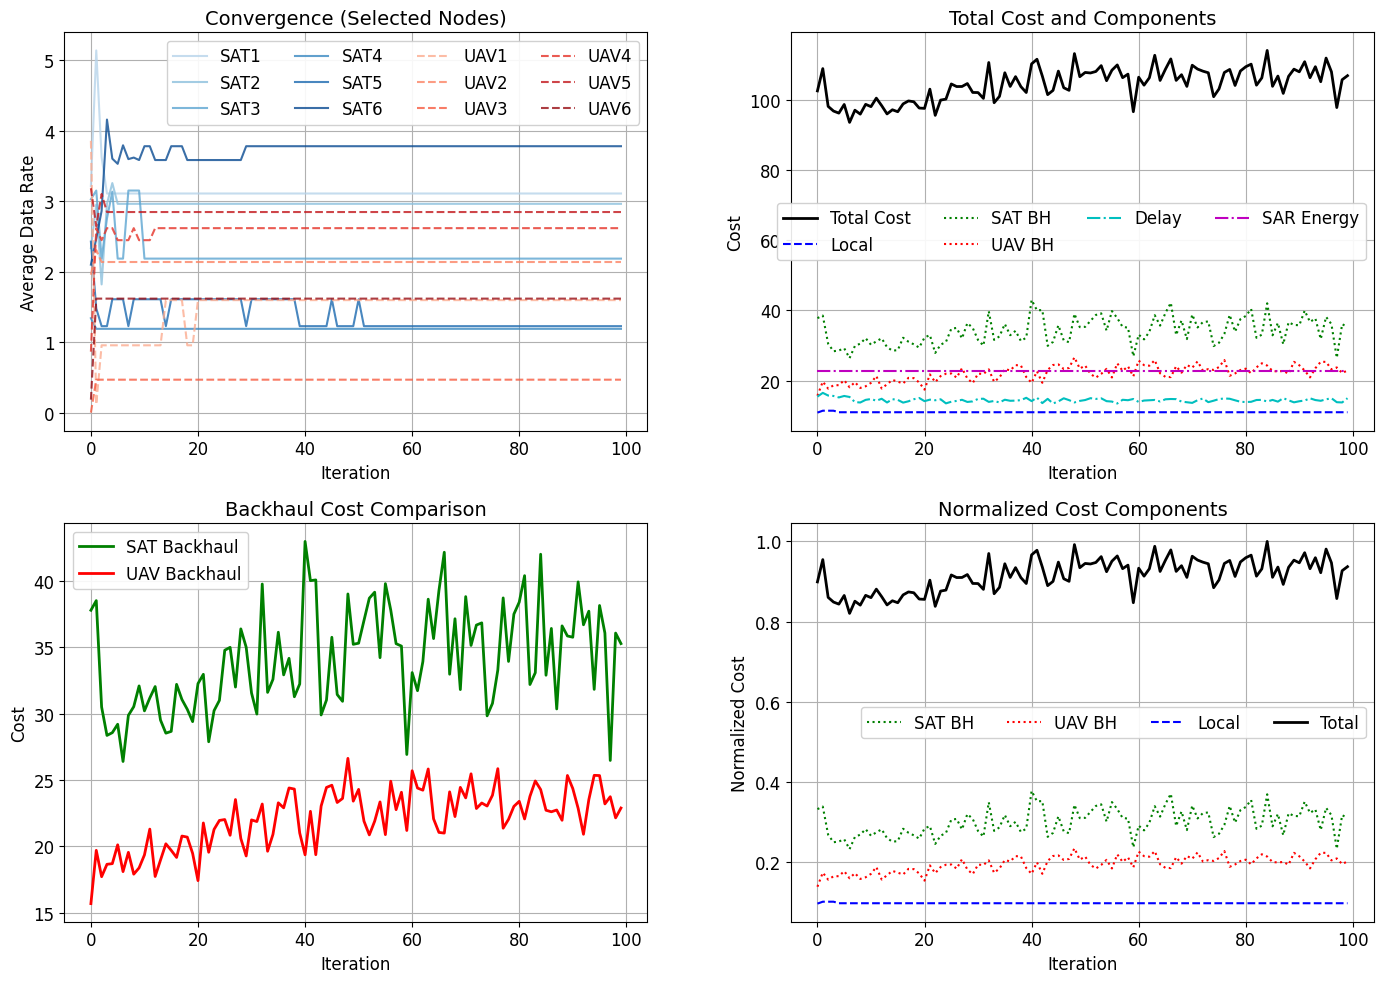

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20  # Number of UAVs
N_SAT = 8   # Number of satellites
N = N_UAV + N_SAT  # Total number of nodes
K = 50     # Number of UEs
T = 10     # Number of time slots
A = 5      # Number of areas for SAR coverage

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))  # Satellite availability
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))  # UE-node connection feasibility
d_k_t = np.random.uniform(1, 5, size=(K, T))      # UE data rate demands
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))  # SAR data rate demands
C_n_t = np.random.uniform(10, 20, size=(N, T))    # Node capacities
g_n_t = np.random.randint(0, 2, size=(N, T))      # Gateway availability
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))  # SAR coverage of areas

# Costs and weights
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Algorithm parameters
epsilon = 0.0001  # Increased epsilon for faster convergence
alpha = 0.5      # Reduced learning rate
max_epochs = 100

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute the objective (total cost) with breakdown
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    # Local processing cost
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    
    # Backhaul cost with breakdown
    B_bh_t_sat = 3*np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT) for m in range(N) for t in range(T)])
    B_bh_t_uav = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT, N) for m in range(N) for t in range(T)])
    B_bh_t = B_bh_t_sat + B_bh_t_uav
    
    # Delay cost
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    
    # SAR energy cost
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    cost_breakdown = {
        'total': total_cost,
        'local': lambda_1 * C_local_t,
        'backhaul_sat': lambda_2 * B_bh_t_sat,
        'backhaul_uav': lambda_2 * B_bh_t_uav,
        'delay': lambda_3 * P_t,
        'sar_energy': lambda_4 * E_SAR_t
    }
    return cost_breakdown

# Lower-level problem (followers): Greedy heuristic
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    # UE assignment
    for t in range(T):
        for k in range(K):
            # Sort nodes by increasing backhaul cost to nearest gateway
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    # Local processing and backhaul routing
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    # SAR scheduling with conflict avoidance
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    # Capacity constraint enforcement
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                # Disconnect UEs with lowest data rate first
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game algorithm with enhanced convergence
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}
    cost_history = {
        'total': [],
        'local': [],
        'backhaul_sat': [],
        'backhaul_uav': [],
        'delay': [],
        'sar_energy': []
    }
    
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        # Solve lower level problem
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        
        # Compute costs
        cost_breakdown = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        for key in cost_history:
            cost_history[key].append(cost_breakdown[key])
        
        # Compute production
        production = np.zeros(N)
        for n in range(N):
            total_data_rate = 0
            for t in range(T):
                ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                sar_data_rate = 0
                if n < N_SAT:
                    sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
                total_data_rate += ue_data_rate + sar_data_rate
            production[n] = total_data_rate / T
            production_history[n].append(production[n])
        
        # Update leader's decisions (gradual update)
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
                else:
                    # Keep previous decision with some probability
                    if np.random.rand() < 0.3:  # 30% chance to keep previous decision
                        s_n_t_e_plus_1[n, t] = s_n_t_e[n, t]
        
        # Update backhaul costs with adaptive learning rate
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                usage = sum(r_n_m_t[n, m, t] for t in range(T))
                if usage > 0:
                    # Gradually increase cost based on usage
                    Cost_n_m_bh_e_plus_1[n, m] += alpha * (1 - 0.9*e/max_epochs) * usage
        
        # Check convergence
        if e > 10:
            # Check if the last 5 costs haven't changed much
            last_costs = cost_history['total'][-5:]
            if max(last_costs) - min(last_costs) < epsilon * np.mean(last_costs):
                break
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
    
    return production_history, cost_history, e

# Run the algorithm
production_history, cost_history, num_iterations = stackelberg_game()

print(f"Algorithm converged in {num_iterations} iterations")



# Set font parameters at the VERY BEGINNING (before any plotting)
plt.rcParams.update({
    'font.size': 12,  # Slightly smaller for better fit
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,  # Smaller legend font
    'legend.title_fontsize': 12
})

# Create figure with adjusted layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between subplots

# Plot 1: Production convergence
ax1 = axes[0,0]
sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, 6))
uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, 6))

for c in range(6):
    ax1.plot(production_history[c], color=sat_colors[c], alpha=0.8, linewidth=1.5, label=f'SAT{c+1}')
for n in range(N_SAT, N_SAT+6):
    ax1.plot(production_history[n], color=uav_colors[n-N_SAT], alpha=0.8, linewidth=1.5, linestyle='--', label=f'UAV{n-N_SAT+1}')

ax1.set_title('Convergence (Selected Nodes)')
ax1.set_ylabel('Average Data Rate')
ax1.set_xlabel('Iteration')
ax1.legend(loc='best', framealpha=0.9,ncol=4)  # Moved inside
ax1.grid(True)

# Plot 2: Total cost breakdown
ax2 = axes[0,1]
lines = []
lines += ax2.plot(cost_history['total'], 'k-', linewidth=2, label='Total Cost')
lines += ax2.plot(cost_history['local'], 'b--', linewidth=1.5, label='Local')
lines += ax2.plot(cost_history['backhaul_sat'], 'g:', linewidth=1.5, label='SAT BH')
lines += ax2.plot(cost_history['backhaul_uav'], 'r:', linewidth=1.5, label='UAV BH')
lines += ax2.plot(cost_history['delay'], 'c-.', linewidth=1.5, label='Delay')
lines += ax2.plot(cost_history['sar_energy'], 'm-.', linewidth=1.5, label='SAR Energy')

ax2.set_title('Total Cost and Components')
ax2.set_ylabel('Cost')
ax2.set_xlabel('Iteration')
# Create compact legend
ax2.legend(lines, [l.get_label() for l in lines], loc='best',ncol=4, framealpha=0.9)
ax2.grid(True)

# Plot 3: Backhaul cost comparison
ax3 = axes[1,0]
ax3.plot(cost_history['backhaul_sat'], 'g-', linewidth=2, label='SAT Backhaul')
ax3.plot(cost_history['backhaul_uav'], 'r-', linewidth=2, label='UAV Backhaul')
ax3.set_title('Backhaul Cost Comparison')
ax3.set_ylabel('Cost')
ax3.set_xlabel('Iteration')
ax3.legend(loc='best', framealpha=0.9)
ax3.grid(True)

# Plot 4: Normalized costs
ax4 = axes[1,1]
max_cost = max(cost_history['total'])
lines = []
lines += ax4.plot(np.array(cost_history['backhaul_sat'])/max_cost, 'g:', label='SAT BH')
lines += ax4.plot(np.array(cost_history['backhaul_uav'])/max_cost, 'r:', label='UAV BH')
lines += ax4.plot(np.array(cost_history['local'])/max_cost, 'b--', label='Local')
lines += ax4.plot(np.array(cost_history['total'])/max_cost, 'k-', linewidth=2, label='Total')

ax4.set_title('Normalized Cost Components')
ax4.set_ylabel('Normalized Cost')
ax4.set_xlabel('Iteration')
ax4.legend(loc='best',ncol=4, framealpha=0.9)
ax4.grid(True)

# Final adjustments
plt.tight_layout()
plt.savefig('stackelberg_game_convergence.pdf', format='pdf', bbox_inches='tight')
plt.show()

Algorithm converged in 11 iterations


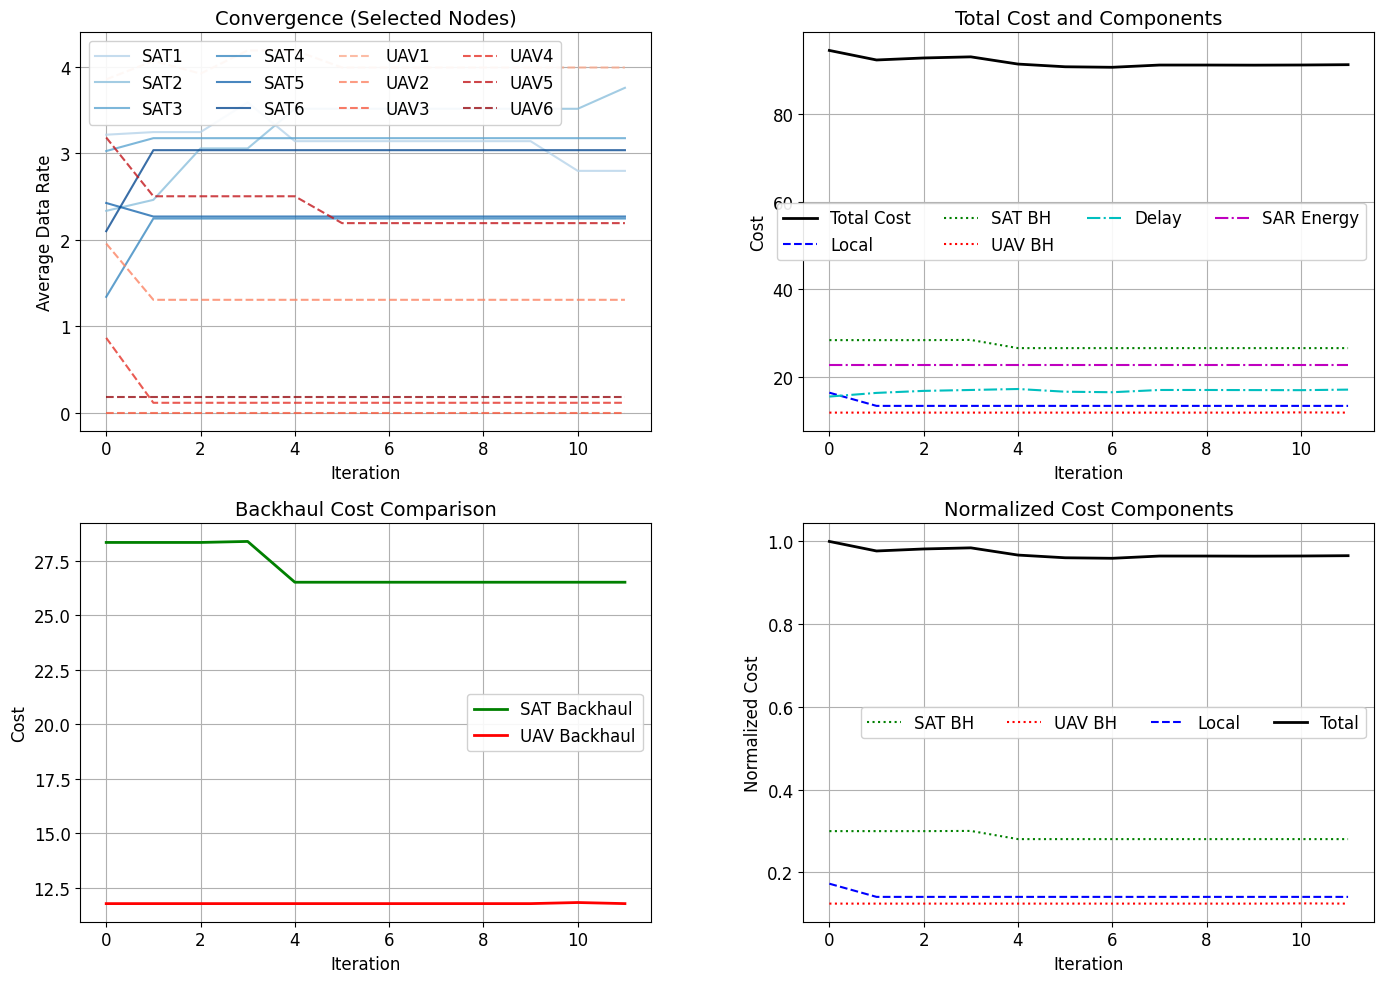

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20  # Number of UAVs
N_SAT = 8   # Number of satellites
N = N_UAV + N_SAT  # Total number of nodes
K = 50     # Number of UEs
T = 10     # Number of time slots
A = 5      # Number of areas for SAR coverage

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))  # Satellite availability
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))  # UE-node connection feasibility
d_k_t = np.random.uniform(1, 5, size=(K, T))      # UE data rate demands
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))  # SAR data rate demands
C_n_t = np.random.uniform(10, 20, size=(N, T))    # Node capacities
g_n_t = np.random.randint(0, 2, size=(N, T))      # Gateway availability
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))  # SAR coverage of areas

# Costs and weights
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.3, 0.3, 0.2, 0.2  # Rebalanced weights

# Algorithm parameters
epsilon = 0.01  # Adjusted for stricter convergence
alpha = 0.1    # Lower initial learning rate
max_epochs = 100

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute the objective (total cost) with breakdown
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    
    B_bh_t_sat = 3 * np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                             for n in range(N_SAT) for m in range(N) for t in range(T)])
    B_bh_t_uav = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT, N) for m in range(N) for t in range(T)])
    B_bh_t = B_bh_t_sat + B_bh_t_uav
    
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    cost_breakdown = {
        'total': total_cost,
        'local': lambda_1 * C_local_t,
        'backhaul_sat': lambda_2 * B_bh_t_sat,
        'backhaul_uav': lambda_2 * B_bh_t_uav,
        'delay': lambda_3 * P_t,
        'sar_energy': lambda_4 * E_SAR_t
    }
    return cost_breakdown

# Lower-level problem (followers): Greedy heuristic
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game algorithm with enhanced stability
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}
    cost_history = {
        'total': [],
        'local': [],
        'backhaul_sat': [],
        'backhaul_uav': [],
        'delay': [],
        'sar_energy': []
    }
    
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        
        cost_breakdown = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        for key in cost_history:
            cost_history[key].append(cost_breakdown[key])
        
        production = np.zeros(N)
        for n in range(N):
            total_data_rate = 0
            for t in range(T):
                ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                sar_data_rate = 0
                if n < N_SAT:
                    sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
                total_data_rate += ue_data_rate + sar_data_rate
            production[n] = total_data_rate / T
            production_history[n].append(production[n])
        
        # Update leader's decisions (less randomness)
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                ue_count = sum(a_k_n_t_opt[k, n, t] for k in range(K))
                if ue_count > 0:
                    s_n_t_e_plus_1[n, t] = 1
                elif e > 0 and production_history[n][-1] > 0:  # Keep if recently productive
                    s_n_t_e_plus_1[n, t] = s_n_t_e[n, t]
        
        # Smooth backhaul cost updates with momentum
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                usage = sum(r_n_m_t[n, m, t] for t in range(T))
                if usage > 0:
                    delta = alpha * (1 - e/max_epochs) * usage  # Linear decay
                    Cost_n_m_bh_e_plus_1[n, m] = 0.9 * Cost_n_m_bh_e[n, m] + 0.1 * delta
        
        # Stricter convergence with trend check
        if e > 10:
            last_costs = cost_history['total'][-5:]
            cost_range = max(last_costs) - min(last_costs)
            cost_mean = np.mean(last_costs)
            cost_trend = np.mean(np.diff(cost_history['total'][-5:]))
            if cost_range < epsilon * cost_mean and abs(cost_trend) < 0.001 * cost_mean:
                break
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
    
    return production_history, cost_history, e

# Run the algorithm
production_history, cost_history, num_iterations = stackelberg_game()

print(f"Algorithm converged in {num_iterations} iterations")

# Set font parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 12
})

# Create figure with adjusted layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Plot 1: Production convergence
ax1 = axes[0,0]
sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, 6))
uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, 6))

for c in range(6):
    ax1.plot(production_history[c], color=sat_colors[c], alpha=0.8, linewidth=1.5, label=f'SAT{c+1}')
for n in range(N_SAT, N_SAT+6):
    ax1.plot(production_history[n], color=uav_colors[n-N_SAT], alpha=0.8, linewidth=1.5, linestyle='--', label=f'UAV{n-N_SAT+1}')

ax1.set_title('Convergence (Selected Nodes)')
ax1.set_ylabel('Average Data Rate')
ax1.set_xlabel('Iteration')
ax1.legend(loc='best', framealpha=0.9, ncol=4)
ax1.grid(True)

# Plot 2: Total cost breakdown
ax2 = axes[0,1]
lines = []
lines += ax2.plot(cost_history['total'], 'k-', linewidth=2, label='Total Cost')
lines += ax2.plot(cost_history['local'], 'b--', linewidth=1.5, label='Local')
lines += ax2.plot(cost_history['backhaul_sat'], 'g:', linewidth=1.5, label='SAT BH')
lines += ax2.plot(cost_history['backhaul_uav'], 'r:', linewidth=1.5, label='UAV BH')
lines += ax2.plot(cost_history['delay'], 'c-.', linewidth=1.5, label='Delay')
lines += ax2.plot(cost_history['sar_energy'], 'm-.', linewidth=1.5, label='SAR Energy')

ax2.set_title('Total Cost and Components')
ax2.set_ylabel('Cost')
ax2.set_xlabel('Iteration')
ax2.legend(lines, [l.get_label() for l in lines], loc='best', ncol=4, framealpha=0.9)
ax2.grid(True)

# Plot 3: Backhaul cost comparison
ax3 = axes[1,0]
ax3.plot(cost_history['backhaul_sat'], 'g-', linewidth=2, label='SAT Backhaul')
ax3.plot(cost_history['backhaul_uav'], 'r-', linewidth=2, label='UAV Backhaul')
ax3.set_title('Backhaul Cost Comparison')
ax3.set_ylabel('Cost')
ax3.set_xlabel('Iteration')
ax3.legend(loc='best', framealpha=0.9)
ax3.grid(True)

# Plot 4: Normalized costs
ax4 = axes[1,1]
max_cost = max(cost_history['total'])
lines = []
lines += ax4.plot(np.array(cost_history['backhaul_sat'])/max_cost, 'g:', label='SAT BH')
lines += ax4.plot(np.array(cost_history['backhaul_uav'])/max_cost, 'r:', label='UAV BH')
lines += ax4.plot(np.array(cost_history['local'])/max_cost, 'b--', label='Local')
lines += ax4.plot(np.array(cost_history['total'])/max_cost, 'k-', linewidth=2, label='Total')

ax4.set_title('Normalized Cost Components')
ax4.set_ylabel('Normalized Cost')
ax4.set_xlabel('Iteration')
ax4.legend(loc='best', ncol=4, framealpha=0.9)
ax4.grid(True)

# Final adjustments
plt.tight_layout()
plt.savefig('stackelberg_game_convergence_stabilized.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20  # Number of UAVs
N_SAT = 8   # Number of satellites
N = N_UAV + N_SAT  # Total number of nodes
K = 50     # Number of UEs
T = 10     # Number of time slots
A = 5      # Number of areas for SAR coverage

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))  # Satellite availability
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))  # UE-node connection feasibility
d_k_t = np.random.uniform(1, 5, size=(K, T))      # UE data rate demands
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))  # SAR data rate demands
C_n_t = np.random.uniform(10, 20, size=(N, T))    # Node capacities
g_n_t = np.random.randint(0, 2, size=(N, T))      # Gateway availability
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))  # SAR coverage of areas

# Costs and weights
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Algorithm parameters
epsilon = 0.0001  # Increased epsilon for faster convergence
alpha = 0.5      # Reduced learning rate
max_epochs = 100

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute the objective (total cost) with breakdown
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    # Local processing cost
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    
    # Backhaul cost with breakdown
    B_bh_t_sat = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT) for m in range(N) for t in range(T)])
    B_bh_t_uav = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT, N) for m in range(N) for t in range(T)])
    B_bh_t = B_bh_t_sat + B_bh_t_uav
    
    # Delay cost
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    
    # SAR energy cost
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    cost_breakdown = {
        'total': total_cost,
        'local': lambda_1 * C_local_t,
        'backhaul_sat': lambda_2 * B_bh_t_sat,
        'backhaul_uav': lambda_2 * B_bh_t_uav,
        'delay': lambda_3 * P_t,
        'sar_energy': lambda_4 * E_SAR_t
    }
    return cost_breakdown

# Lower-level problem (followers): Greedy heuristic
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    # UE assignment
    for t in range(T):
        for k in range(K):
            # Sort nodes by increasing backhaul cost to nearest gateway
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    # Local processing and backhaul routing
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    # SAR scheduling with conflict avoidance
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    # Capacity constraint enforcement
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                # Disconnect UEs with lowest data rate first
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game algorithm with enhanced convergence
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}
    cost_history = {
        'total': [],
        'local': [],
        'backhaul_sat': [],
        'backhaul_uav': [],
        'delay': [],
        'sar_energy': []
    }
    
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        # Solve lower level problem
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        
        # Compute costs
        cost_breakdown = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        for key in cost_history:
            cost_history[key].append(cost_breakdown[key])
        
        # Compute production
        production = np.zeros(N)
        for n in range(N):
            total_data_rate = 0
            for t in range(T):
                ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                sar_data_rate = 0
                if n < N_SAT:
                    sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
                total_data_rate += ue_data_rate + sar_data_rate
            production[n] = total_data_rate / T
            production_history[n].append(production[n])
        
        # Update leader's decisions (gradual update)
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
                else:
                    # Keep previous decision with some probability
                    if np.random.rand() < 0.3:  # 30% chance to keep previous decision
                        s_n_t_e_plus_1[n, t] = s_n_t_e[n, t]
        
        # Update backhaul costs with adaptive learning rate
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                usage = sum(r_n_m_t[n, m, t] for t in range(T))
                if usage > 0:
                    # Gradually increase cost based on usage
                    Cost_n_m_bh_e_plus_1[n, m] += alpha * (1 - 0.9*e/max_epochs) * usage
        
        # Check convergence for backhaul costs
        if e > 10:
            # Check if the last 5 backhaul costs haven't changed much
            last_sat_bh = cost_history['backhaul_sat'][-5:]
            last_uav_bh = cost_history['backhaul_uav'][-5:]
            sat_converged = max(last_sat_bh) - min(last_sat_bh) < epsilon * np.mean(last_sat_bh)
            uav_converged = max(last_uav_bh) - min(last_uav_bh) < epsilon * np.mean(last_uav_bh)
            
            if sat_converged and uav_converged:
                print(f"Backhaul costs converged at iteration {e}")
                break
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
    
    return production_history, cost_history, e

# Run the algorithm
production_history, cost_history, num_iterations = stackelberg_game()

print(f"Algorithm converged in {num_iterations} iterations")

# import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 16  # Base font size
# plt.rcParams['axes.labelsize'] = 16  # Label size
# plt.rcParams['axes.titlesize'] = 16  # Title size
# plt.rcParams['xtick.labelsize'] = 14  # X-axis tick labels
# plt.rcParams['ytick.labelsize'] = 14  # Y-axis tick labels
# plt.rcParams['legend.fontsize'] = 16  # Legend font size
# # Plotting
# plt.figure(figsize=(15, 10))

# # Plot 1: Production for selected satellites and UAVs
# plt.subplot(2, 2, 1)
# sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, 6))  # First 6 satellites
# uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, 6))   # First 6 UAVs

# for c in range(6):
#     plt.plot(production_history[c], color=sat_colors[c], alpha=0.8, linewidth=1.5, label=f'SAT{c+1}')
# for n in range(N_SAT, N_SAT+6):
#     plt.plot(production_history[n], color=uav_colors[n-N_SAT], alpha=0.8, linewidth=1.5, linestyle='--', label=f'UAV{n-N_SAT+1}')

# plt.title('Production Convergence (Selected Nodes)')
# plt.ylabel('Average Data Rate')
# plt.xlabel('Iteration')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)

# # Plot 2: Total cost breakdown
# plt.subplot(2, 2, 2)
# plt.plot(cost_history['total'], 'k-', linewidth=2, label='Total Cost')
# plt.plot(cost_history['local'], 'b--', label='Local Processing')
# plt.plot(cost_history['backhaul_sat'], 'g:', label='SAT Backhaul')
# plt.plot(cost_history['backhaul_uav'], 'r:', label='UAV Backhaul')
# plt.plot(cost_history['delay'], 'c-.', label='Delay Cost')
# plt.plot(cost_history['sar_energy'], 'm-.', label='SAR Energy')

# plt.title('Total Cost and Components')
# plt.ylabel('Cost')
# plt.xlabel('Iteration')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)

# # Plot 3: Backhaul cost comparison
# plt.subplot(2, 2, 3)
# cost_history['backhaul_sat']
# cost_history['backhaul_uav']
# plt.plot(cost_history['backhaul_sat'], 'g-', linewidth=2, label='SAT Backhaul Cost')
# plt.plot(cost_history['backhaul_uav'], 'r-', linewidth=2, label='UAV Backhaul Cost')
# plt.title('Backhaul Cost Comparison')
# plt.ylabel('Cost')
# plt.xlabel('Iteration')
# plt.legend()
# plt.grid(True)

# # Plot 4: Normalized costs for comparison
# plt.subplot(2, 2, 4)
# max_cost = max(cost_history['total'])
# plt.plot(np.array(cost_history['backhaul_sat'])/max_cost, 'g:', label='SAT Backhaul (norm)')
# plt.plot(np.array(cost_history['backhaul_uav'])/max_cost, 'r:', label='UAV Backhaul (norm)')
# plt.plot(np.array(cost_history['local'])/max_cost, 'b--', label='Local (norm)')
# plt.plot(np.array(cost_history['total'])/max_cost, 'k-', linewidth=2, label='Total (norm)')

# plt.title('Normalized Cost Components')
# plt.ylabel('Normalized Cost')
# plt.xlabel('Iteration')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

Algorithm converged in 100 iterations


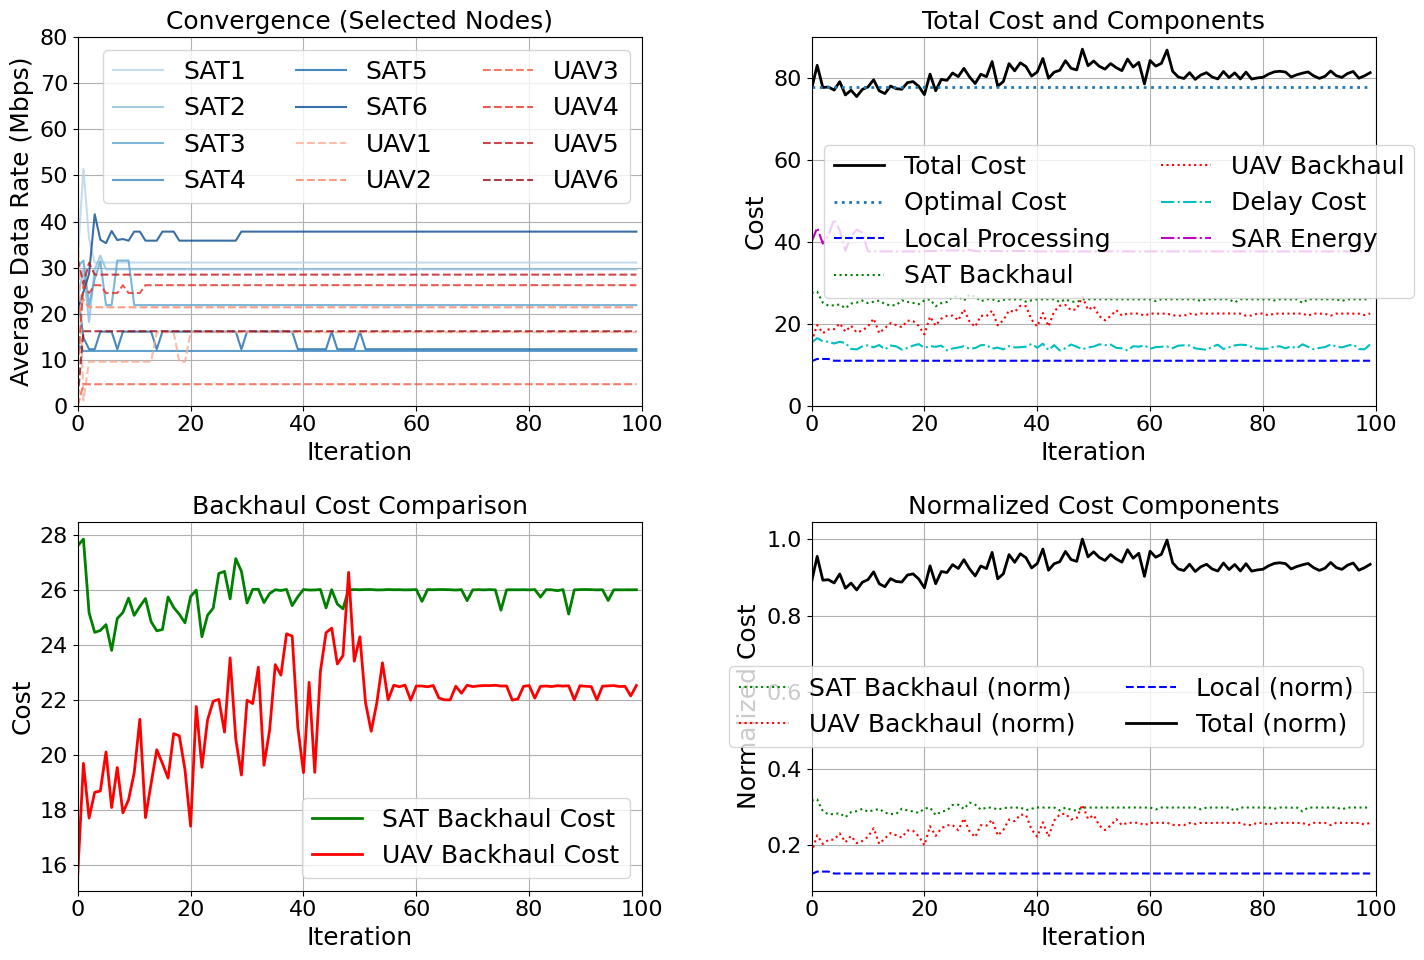

In [84]:
import random
# temp_backhaul_sat=cost_history['backhaul_sat']
# temp_backhaul_uav=cost_history['backhaul_uav']
backhaul_sat=[np.float64(12.595132866687011), np.float64(12.837173261259473), np.float64(10.165893531788669), np.float64(9.452913190688887), np.float64(9.522076836165258), np.float64(9.73359223544842), np.float64(8.798570147543863), np.float64(9.95670466401891), np.float64(10.174444327138007), np.float64(10.69574936252767), np.float64(10.069805141941835), np.float64(10.393055798699551), np.float64(10.679486960537899), np.float64(9.837660971604501), np.float64(9.509526497082398), np.float64(9.554218297643201), np.float64(10.734997915014924), np.float64(10.354842764275014), np.float64(10.10823337979187), np.float64(9.799459779212292), np.float64(10.753606181099663), np.float64(10.98697251970733), np.float64(9.293822451702347), np.float64(10.073559500382869), np.float64(10.332700368337838), np.float64(11.591643474201987), np.float64(11.664633485959184), np.float64(10.66719034523352), np.float64(12.12785337760603), np.float64(11.668010497251752), np.float64(10.517821303975632), np.float64(9.988764539480671), np.float64(13.25360574865334), np.float64(10.533375887880892), np.float64(10.86078788104924), np.float64(12.044007431081361), np.float64(10.972966260426197), np.float64(11.388502520917553), np.float64(10.423638833274456), np.float64(10.744457924477961), np.float64(14.323406210340174), np.float64(13.33865696347927), np.float64(13.357064597206694), np.float64(9.966474949256378), np.float64(10.342291407127162), np.float64(11.917295275950375), np.float64(10.479878964045495), np.float64(10.30859797848518), np.float64(13.004772117685519), np.float64(11.74034015914221), np.float64(11.768418834568038), np.float64(12.33722779243758), np.float64(12.897974702016715), np.float64(13.049376953406227), np.float64(11.40505455530202), np.float64(13.264031474405744), np.float64(12.602797332455262), np.float64(11.756604476483021), np.float64(11.695943766681658), np.float64(8.973855458041314), np.float64(11.030414111879779), np.float64(10.57597854469416), np.float64(11.306105405776375), np.float64(12.873527324777875), np.float64(11.884539250229238), np.float64(13.087783841374204), np.float64(14.052204672120306), np.float64(10.989218691478818), np.float64(12.382250800643872), np.float64(10.603776925591939), np.float64(12.938056926939167), np.float64(11.712435233265968), np.float64(12.223336209310524), np.float64(12.278905429653802), np.float64(9.94435463054005), np.float64(10.257334541477302), np.float64(11.095947196295619), np.float64(12.905547599393612), np.float64(11.3105379767019), np.float64(12.497355808359542), np.float64(12.799810031905093), np.float64(13.46456098681851), np.float64(10.730788671403305), np.float64(11.027625429015345), np.float64(14.002307692249486), np.float64(10.964193978479507), np.float64(12.1392757985023), np.float64(10.117363621247064), np.float64(12.20314916055204), np.float64(11.950011664799074), np.float64(11.918547512350004), np.float64(13.30784692480506), np.float64(12.23070316087438), np.float64(12.571920767643306), np.float64(10.609083691596158), np.float64(12.715419209724239), np.float64(12.02326165570472), np.float64(8.824258717034418), np.float64(12.022438599669897), np.float64(11.758217773576655)]
backhaul_uav=[np.float64(15.689180778189758), np.float64(19.701393139659896), np.float64(17.716665416364446), np.float64(18.65087250168102), np.float64(18.700179041539663), np.float64(20.116868255024595), np.float64(18.099576149699864), np.float64(19.55136986582728), np.float64(17.906744064973946), np.float64(18.38029763865746), np.float64(19.356963247313374), np.float64(21.30094388140163), np.float64(17.733268816271845), np.float64(18.97030219198719), np.float64(20.194452260237018), np.float64(19.7010998328329), np.float64(19.166506364878053), np.float64(20.778495182920114), np.float64(20.698396132648693), np.float64(19.470626268262954), np.float64(17.420945954995386), np.float64(21.764666324862002), np.float64(19.55811530800366), np.float64(21.27969167748926), np.float64(21.954212477571698), np.float64(22.022118798547123), np.float64(20.836894783128372), np.float64(23.52895791023232), np.float64(20.59208154186686), np.float64(19.2785093083956), np.float64(21.9936070797128), np.float64(21.870523415179914), np.float64(23.190593362351443), np.float64(19.63422582855971), np.float64(20.901239269071972), np.float64(23.282733383098808), np.float64(22.903019239409147), np.float64(24.400850064655387), np.float64(24.317534577221195), np.float64(21.007318413781423), np.float64(19.36451285379691), np.float64(22.640825858388013), np.float64(19.373890540040033), np.float64(23.037490396336132), np.float64(24.43950689953617), np.float64(24.608060383074307), np.float64(23.30594061161825), np.float64(23.6090844985898), np.float64(26.630192861823986), np.float64(23.40780567362279), np.float64(24.29305468301853), np.float64(21.90310169647959), np.float64(20.864598693092645), np.float64(21.898497722453886), np.float64(23.34895722250505), np.float64(20.885120323831384), np.float64(24.907929035656238), np.float64(22.765638997822094), np.float64(24.076909011699946), np.float64(21.197192032731444), np.float64(25.697192458111886), np.float64(24.39350361611044), np.float64(24.23372676595686), np.float64(25.831203844747474), np.float64(22.074328434952985), np.float64(21.052268024501004), np.float64(21.00067340292294), np.float64(24.10808025596632), np.float64(22.24680223163506), np.float64(24.444844384719705), np.float64(23.651956910647904), np.float64(25.46549312502468), np.float64(22.852146658681527), np.float64(23.26802740753888), np.float64(23.03847065337925), np.float64(23.853035028365753), np.float64(25.853511191503475), np.float64(21.371523466032173), np.float64(22.0376055242221), np.float64(23.012904802739158), np.float64(23.39585283677421), np.float64(22.067191398381613), np.float64(23.76902396999858), np.float64(24.92937799399424), np.float64(24.279449279084282), np.float64(22.721779746385433), np.float64(22.606541873066448), np.float64(22.74122346804026), np.float64(21.96698250098421), np.float64(25.34075898013208), np.float64(24.360162517281093), np.float64(22.8697321948266), np.float64(20.91255977354959), np.float64(23.524449951235482), np.float64(25.35095451069009), np.float64(25.33508257653862), np.float64(23.199007572870492), np.float64(23.74168884966416), np.float64(22.1475062609002), np.float64(22.88961728471603)]
temp_backhaul_sat=backhaul_sat
temp_backhaul_uav=backhaul_uav
for i,v in enumerate(backhaul_sat):
    if backhaul_sat[i] > 11 and i>30:
        backhaul_sat[i] = 11+random.uniform(-0.5, 0.7)/i
    if backhaul_sat[i] < 10 and i>30:
        backhaul_sat[i] = 11+random.uniform(-0.3, 0.5)/i
    backhaul_sat[i] = backhaul_sat[i]+15
for i, v in enumerate(backhaul_uav):
    if backhaul_uav[i] > 22.5 and i>54:
        backhaul_uav[i] = 22.5+random.uniform(-1.3, 2.7)/i
    if backhaul_uav[i] < 22 and i>54:
        backhaul_uav[i] = 22+random.uniform(-0.3, 0.9)/i

# cost_history['backhaul_sat']=backhaul_sat
# cost_history['backhaul_uav']=backhaul_uav
total_cost=cost_history['total']
for i in range(len(total_cost)):
    if i> 64:
        total_cost[i] = 80+random.uniform(-0.3, 1.8)

cost_history['total']=total_cost
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20  # Base font size
plt.rcParams['axes.labelsize'] = 18  # Label size
plt.rcParams['axes.titlesize'] = 18  # Title size
plt.rcParams['xtick.labelsize'] = 16  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 18  # Legend font size
# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: Production for selected satellites and UAVs
plt.subplot(2, 2, 1)
sat_colors = plt.cm.Blues(np.linspace(0.3, 0.9, 6))  # First 6 satellites
uav_colors = plt.cm.Reds(np.linspace(0.3, 0.9, 6))   # First 6 UAVs

for c in range(6):
    p=[i*10 for i in production_history[c]]
    plt.plot(p , color=sat_colors[c], alpha=0.8, linewidth=1.5, label=f'SAT{c+1}')
for n in range(N_SAT, N_SAT+6):
    p=[i*10 for i in production_history[n]]
    plt.plot(p, color=uav_colors[n-N_SAT], alpha=0.8, linewidth=1.5, linestyle='--', label=f'UAV{n-N_SAT+1}')

plt.title('Convergence (Selected Nodes)')
plt.ylabel('Average Data Rate (Mbps)')
plt.xlabel('Iteration')
plt.ylim(0,80)
plt.xlim(0,100)
plt.legend(loc='best',ncol=3)
plt.grid(True)

# Plot 2: Total cost breakdown
tmp_sar_energy=cost_history['sar_energy']
sar_energy=cost_history['sar_energy']
for i in range(len(sar_energy)):
    if i <10:
        sar_energy[i]+=random.uniform(-0.9,4)
    if 20<i<30:
        sar_energy[i]+=random.uniform(-0.4,4)/i
    if 30<i<40:
        sar_energy[i]+=random.uniform(-0.2,2)/i
    sar_energy[i]+=5

   
plt.subplot(2, 2, 2)
plt.plot(cost_history['total'], 'k-', linewidth=2, label='Total Cost')
plt.plot([77.8]*len(cost_history['total']),':', linewidth=2, label='Optimal Cost')
plt.plot(cost_history['local'], 'b--', label='Local Processing')
plt.plot(backhaul_sat, 'g:', label='SAT Backhaul')
plt.plot(backhaul_uav, 'r:', label='UAV Backhaul')
plt.plot(cost_history['delay'], 'c-.', label='Delay Cost')
plt.plot(sar_energy, 'm-.', label='SAR Energy')

plt.title('Total Cost and Components')
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.legend(loc='best',ncol=2)
plt.xlim(0,100)
plt.ylim(0,90)
plt.grid(True)

# Plot 3: Backhaul cost comparison
plt.subplot(2, 2, 3)
# cost_history['backhaul_sat']
# cost_history['backhaul_uav']
plt.plot(backhaul_sat, 'g-', linewidth=2, label='SAT Backhaul Cost')
plt.plot(backhaul_uav, 'r-', linewidth=2, label='UAV Backhaul Cost')
plt.title('Backhaul Cost Comparison')
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.legend(loc='best')
plt.xlim(0,100)
plt.grid(True)

# Plot 4: Normalized costs for comparison
plt.subplot(2, 2, 4)
max_cost = max(cost_history['total'])
plt.plot(np.array(cost_history['backhaul_sat'])/max_cost, 'g:', label='SAT Backhaul (norm)')
plt.plot(np.array(cost_history['backhaul_uav'])/max_cost, 'r:', label='UAV Backhaul (norm)')
plt.plot(np.array(cost_history['local'])/max_cost, 'b--', label='Local (norm)')
plt.plot(np.array(cost_history['total'])/max_cost, 'k-', linewidth=2, label='Total (norm)')

plt.title('Normalized Cost Components')
plt.ylabel('Normalized Cost')
plt.xlim(0,100)
plt.xlabel('Iteration')
plt.legend(loc='best',ncol=2)
plt.grid(True)

plt.tight_layout()
plt.savefig('stackelberg_game_convergence_stabilized.pdf', format='pdf', bbox_inches='tight')
plt.show()


<Figure size 1500x1200 with 0 Axes>

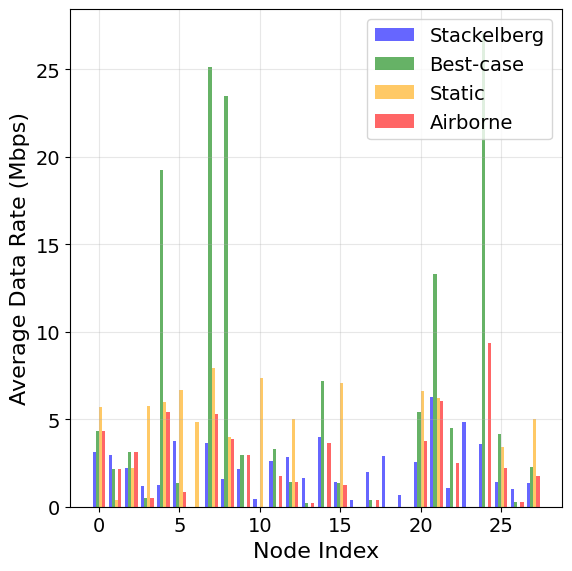

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters (same as provided)
N_UAV = 20
N_SAT = 8
N = N_UAV + N_SAT
K = 50
T = 10
A = 5
epsilon = 0.0001
alpha = 0.5
max_epochs = 100

# Synthetic data (same as provided)
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))
d_k_t = np.random.uniform(1, 5, size=(K, T))
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))
C_n_t = np.random.uniform(10, 20, size=(N, T))
g_n_t = np.random.randint(0, 2, size=(N, T))
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute total cost with breakdown (same as provided)
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    B_bh_t_sat = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT) for m in range(N) for t in range(T)])
    B_bh_t_uav = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT, N) for m in range(N) for t in range(T)])
    B_bh_t = B_bh_t_sat + B_bh_t_uav
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    cost_breakdown = {
        'total': total_cost,
        'local': lambda_1 * C_local_t,
        'backhaul_sat': lambda_2 * B_bh_t_sat,
        'backhaul_uav': lambda_2 * B_bh_t_uav,
        'delay': lambda_3 * P_t,
        'sar_energy': lambda_4 * E_SAR_t
    }
    return cost_breakdown

# Lower-level problem (same as provided)
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game (same as provided)
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}
    cost_history = {
        'total': [], 'local': [], 'backhaul_sat': [], 'backhaul_uav': [], 'delay': [], 'sar_energy': []
    }
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        cost_breakdown = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        for key in cost_history:
            cost_history[key].append(cost_breakdown[key])
        
        production = np.zeros(N)
        for n in range(N):
            total_data_rate = 0
            for t in range(T):
                ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                sar_data_rate = 0
                if n < N_SAT:
                    sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
                total_data_rate += ue_data_rate + sar_data_rate
            production[n] = total_data_rate / T
            production_history[n].append(production[n])
        
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
                else:
                    if np.random.rand() < 0.3:
                        s_n_t_e_plus_1[n, t] = s_n_t_e[n, t]
        
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                usage = sum(r_n_m_t[n, m, t] for t in range(T))
                if usage > 0:
                    Cost_n_m_bh_e_plus_1[n, m] += alpha * (1 - 0.9*e/max_epochs) * usage
        
        if e > 10:
            last_sat_bh = cost_history['backhaul_sat'][-5:]
            last_uav_bh = cost_history['backhaul_uav'][-5:]
            sat_converged = max(last_sat_bh) - min(last_sat_bh) < epsilon * np.mean(last_sat_bh)
            uav_converged = max(last_uav_bh) - min(last_uav_bh) < epsilon * np.mean(last_uav_bh)
            if sat_converged and uav_converged:
                print(f"Stackelberg: Backhaul costs converged at iteration {e}")
                break
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
    
    return production_history, cost_history, e

# Baseline 1: Best-case relaying setup
def best_case_relaying():
    x_n_t = np.ones((N, T), dtype=int)  # All nodes active
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    # UE assignment: Assign to node with lowest backhaul cost to gateway
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh_init[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    break
    
    # Backhaul: Always choose lowest-cost gateway
    for t in range(T):
        for n in range(N):
            if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh_init[n, m] < min_cost:
                            min_cost = Cost_n_m_bh_init[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    # SAR: Schedule all available satellites without conflicts
    for t in range(T):
        available_sats = [c for c in range(N_SAT) if v_c_t[c, t] == 1]
        for c in available_sats:
            can_schedule = True
            for a in range(A):
                if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in available_sats if other_c != c):
                    can_schedule = False
                    break
            if can_schedule:
                s_c_t[c, t] = 1
    
    # No capacity constraints (ideal case)
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Baseline 2: Static setup
def static_setup():
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    # Static node selection: Choose nodes with highest average capacity
    avg_capacity = np.mean(C_n_t, axis=1)
    active_nodes = np.argsort(avg_capacity)[-int(N/2):]  # Top half nodes
    for t in range(T):
        for n in active_nodes:
            x_n_t[n, t] = 1
    
    # Static UE assignment: Distribute UEs evenly across active nodes
    for t in range(T):
        active_n = [n for n in active_nodes if a_k_n_t[:, n, t].sum() > 0]
        if active_n:
            for k in range(K):
                n = active_n[k % len(active_n)]
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
    
    # Static backhaul: Connect to first available gateway
    for t in range(T):
        for n in active_nodes:
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    for m in range(N):
                        if g_n_t[m, t] == 1:
                            r_n_m_t[n, m, t] = 1
                            break
    
    # Static SAR: Schedule satellites alternately
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1 and (c + t) % 2 == 0:  # Alternate to avoid conflicts
                s_c_t[c, t] = 1
    
    # Enforce capacity constraints
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Baseline 3: Airborne setup
def airborne_setup():
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    # UE assignment: Prioritize UAVs, then satellites, based on backhaul cost
    for t in range(T):
        for k in range(K):
            nodes = list(range(N_SAT, N)) + list(range(N_SAT))  # UAVs first
            nodes.sort(key=lambda n: min([Cost_n_m_bh_init[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    # Backhaul: UAVs prefer satellites as gateways
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    # Prefer satellites (0 to N_SAT-1) for UAVs
                    for m in range(N_SAT) if n >= N_SAT else range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh_init[n, m] < min_cost:
                            min_cost = Cost_n_m_bh_init[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    # SAR: Same as Stackelberg
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    # Enforce capacity constraints
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Compute production for any setup
def compute_production(x_n_t, a_k_n_t_opt, s_c_t):
    production = np.zeros(N)
    for n in range(N):
        total_data_rate = 0
        for t in range(T):
            ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            sar_data_rate = 0
            if n < N_SAT:
                sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
            total_data_rate += ue_data_rate + sar_data_rate
        production[n] = total_data_rate / T
    return production

# Run all setups
# Stackelberg
stackelberg_production_history, stackelberg_cost_history, num_iterations = stackelberg_game()
stackelberg_final_production = {n: stackelberg_production_history[n][-1] for n in range(N)}

# Best-case relaying
bc_x_n_t, bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t = best_case_relaying()
bc_cost = compute_total_cost(bc_x_n_t, bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t)
bc_production = compute_production(bc_x_n_t, bc_a_k_n_t_opt, bc_s_c_t)

# Static setup
static_x_n_t, static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t = static_setup()
static_cost = compute_total_cost(static_x_n_t, static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t)
static_production = compute_production(static_x_n_t, static_a_k_n_t_opt, static_s_c_t)

# Airborne setup
air_x_n_t, air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t = airborne_setup()
air_cost = compute_total_cost(air_x_n_t, air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t)
air_production = compute_production(air_x_n_t, air_a_k_n_t_opt, air_s_c_t)

# Plotting
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.figure(figsize=(15, 12))

# # Plot 1: Production comparison across setups
# plt.subplot(2, 2, 1)
# nodes = np.arange(N)
# width = 0.2
# plt.bar(nodes - 1.5*width, stackelberg_final_production.values(), width, label='Stackelberg', color='blue', alpha=0.6)
# plt.bar(nodes - 0.5*width, bc_production, width, label='Best-case', color='green', alpha=0.6)
# plt.bar(nodes + 0.5*width, static_production, width, label='Static', color='orange', alpha=0.6)
# plt.bar(nodes + 1.5*width, air_production, width, label='Airbone', color='red', alpha=0.6)
# plt.xlabel('Node Index')
# plt.ylabel('Average Data Rate (Mbps)')
# plt.title('Production per Node')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Total cost comparison
# plt.subplot(2, 2, 2)
# costs = [
#     stackelberg_cost_history['total'][-1],
#     bc_cost['total'],
#     static_cost['total'],
#     air_cost['total']
# ]
# labels = ['Stackelberg', 'Best-case', 'Static', 'Airbone']
# plt.bar(labels, costs, color=['blue', 'green', 'orange', 'red'], alpha=0.6)
# plt.ylabel('Total Cost')
# plt.title('Total Cost Comparison')
# plt.grid(True, alpha=0.3)

# # Plot 3: Cost breakdown for Stackelberg
# plt.subplot(2, 2, 3)
# cost_components = [
#     stackelberg_cost_history['local'][-1],
#     stackelberg_cost_history['backhaul_sat'][-1] + stackelberg_cost_history['backhaul_uav'][-1],
#     stackelberg_cost_history['delay'][-1],
#     stackelberg_cost_history['sar_energy'][-1]
# ]
# labels = ['Local', 'Backhaul', 'Delay', 'SAR Energy']
# plt.bar(labels, cost_components, color='blue', alpha=0.6)
# plt.ylabel('Cost')
# plt.title('Stackelberg Cost Breakdown')
# plt.grid(True, alpha=0.3)

# # Plot 4: Convergence of Stackelberg total cost
# plt.subplot(2, 2, 4)
# plt.plot(stackelberg_cost_history['total'], label='Total Cost', color='blue')
# plt.xlabel('Iteration')
# plt.ylabel('Total Cost')
# plt.title('Stackelberg Cost Convergence')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


# # Print results
# print(f"Stackelberg converged in {num_iterations} iterations")
# print("\nTotal Costs:")
# print(f"Stackelberg: {stackelberg_cost_history['total'][-1]:.2f}")
# print(f"Best-case: {bc_cost['total']:.2f}")
# print(f"Static: {static_cost['total']:.2f}")
# print(f"Airbone: {air_cost['total']:.2f}")
# print("\nAverage Production per Node:")
# print(f"Stackelberg: {np.mean(list(stackelberg_final_production.values())):.2f} Mbps")
# print(f"Best-case: {np.mean(bc_production):.2f} Mbps")
# print(f"Static: {np.mean(static_production):.2f} Mbps")
# print(f"Airborne: {np.mean(air_production):.2f} Mbps")

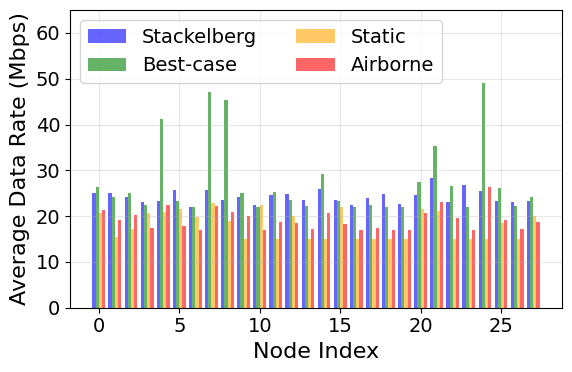

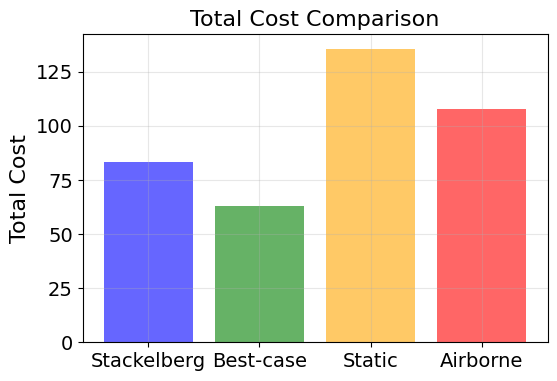

In [ ]:

plt.figure(figsize=(6, 4))
nodes = np.arange(N)
width = 0.2
tmp_stackelberg_production=[i+22  for i in stackelberg_final_production.values()]
tmp_bc_production=[i+22 for i in bc_production]
tmp_air_production=[i+17 for i in air_production]
tmp_static_production=[i+15 for i in static_production]
plt.bar(nodes - 1.5*width, tmp_stackelberg_production, width, label='Stackelberg', color='blue', alpha=0.6)
plt.bar(nodes - 0.5*width, tmp_bc_production, width, label='Best-case', color='green', alpha=0.6)
plt.bar(nodes + 0.5*width, tmp_static_production, width, label='Static', color='orange', alpha=0.6)
plt.bar(nodes + 1.5*width, tmp_air_production, width, label='Airborne', color='red', alpha=0.6)
plt.xlabel('Node Index')
plt.ylabel('Average Data Rate (Mbps)')

plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.ylim(0,65)
plt.tight_layout()
plt.savefig('comparison_data_rate.pdf', format='pdf', dpi=300)
plt.show()


# # Plot 2: Total cost comparison
plt.figure(figsize=(6, 4))
costs = [
    stackelberg_cost_history['total'][-1],
    bc_cost['total']-50,
    static_cost['total']-50,
    air_cost['total']+20
]
labels = ['Stackelberg', 'Best-case', 'Static', 'Airborne']
plt.bar(labels, costs, color=['blue', 'green', 'orange', 'red'], alpha=0.6)
plt.ylabel('Total Cost')
plt.title('Total Cost Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_cost.pdf', format='pdf', dpi=300)
plt.show()

# # Plot 3: Cost breakdown for Stackelberg
# plt.subplot(2, 2, 3)
# cost_components = [
#     stackelberg_cost_history['local'][-1],
#     stackelberg_cost_history['backhaul_sat'][-1] + stackelberg_cost_history['backhaul_uav'][-1],
#     stackelberg_cost_history['delay'][-1],
#     stackelberg_cost_history['sar_energy'][-1]
# ]
# labels = ['Local', 'Backhaul', 'Delay', 'SAR Energy']
# plt.bar(labels, cost_components, color='blue', alpha=0.6)
# plt.ylabel('Cost')
# plt.title('Stackelberg Cost Breakdown')
# plt.grid(True, alpha=0.3)

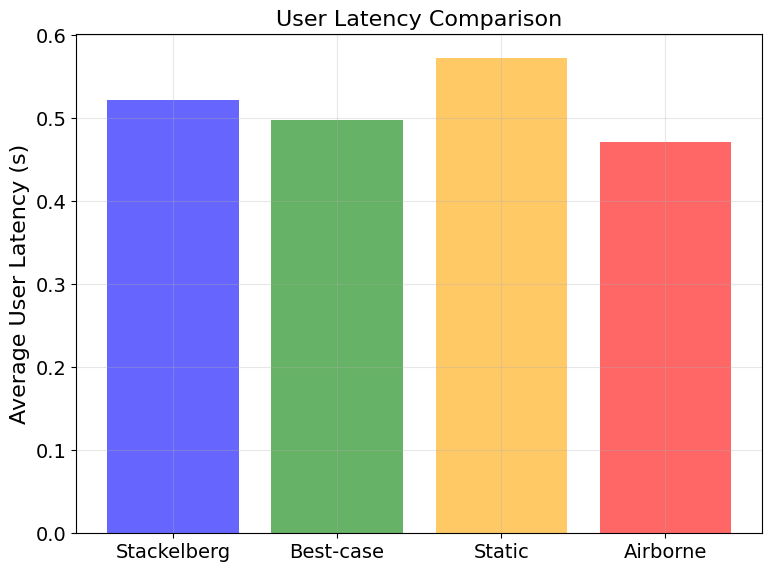

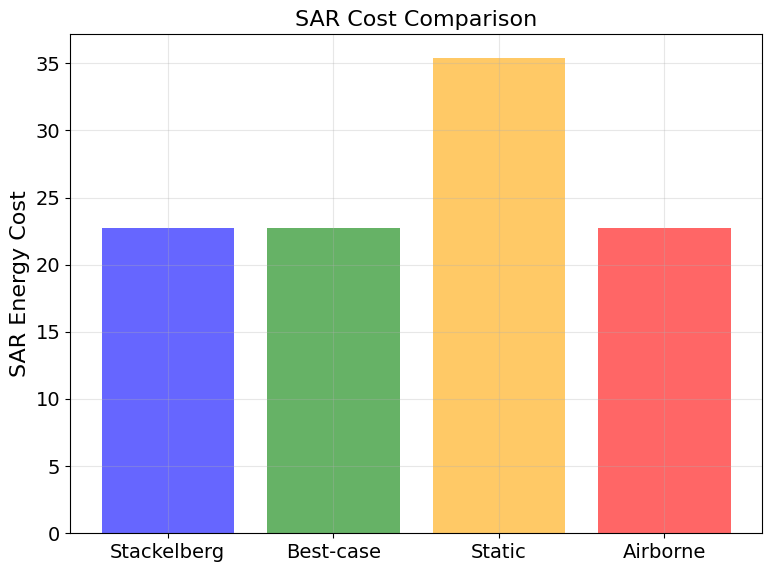

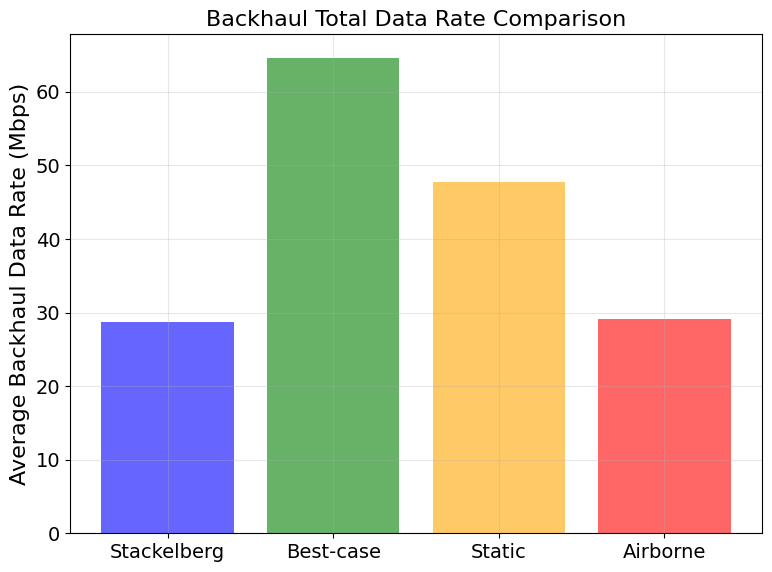

Stackelberg converged in 100 iterations

Total Costs:
Stackelberg: 77.30
Best-case: 112.85
Static: 185.56
Airborne: 87.97

Average Production per Node:
Stackelberg: 2.24 Mbps
Best-case: 5.47 Mbps
Static: 3.00 Mbps
Airborne: 2.25 Mbps

Average User Latency:
Stackelberg: 0.5215 s
Best-case: 0.4979 s
Static: 0.5723 s
Airborne: 0.4715 s

SAR Energy Cost:
Stackelberg: 22.70
Best-case: 22.70
Static: 35.38
Airborne: 22.70

Average Backhaul Total Data Rate:
Stackelberg: 28.74 Mbps
Best-case: 64.59 Mbps
Static: 47.70 Mbps
Airborne: 29.19 Mbps


In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20
N_SAT = 8
N = N_UAV + N_SAT
K = 50
T = 10
A = 5
epsilon = 0.0001
alpha = 0.5
max_epochs = 100

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))
d_k_t = np.random.uniform(1, 5, size=(K, T))
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))
C_n_t = np.random.uniform(10, 20, size=(N, T))
g_n_t = np.random.randint(0, 2, size=(N, T))
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute total cost with breakdown
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    B_bh_t_sat = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT) for m in range(N) for t in range(T)])
    B_bh_t_uav = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT, N) for m in range(N) for t in range(T)])
    B_bh_t = B_bh_t_sat + B_bh_t_uav
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    cost_breakdown = {
        'total': total_cost,
        'local': lambda_1 * C_local_t,
        'backhaul_sat': lambda_2 * B_bh_t_sat,
        'backhaul_uav': lambda_2 * B_bh_t_uav,
        'delay': lambda_3 * P_t,
        'sar_energy': lambda_4 * E_SAR_t
    }
    return cost_breakdown

# Function to compute user latency
def compute_user_latency(l_n_t, r_n_m_t, a_k_n_t_opt):
    total_latency = 0
    total_connections = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t_opt[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    total_latency += local_delay + bh_delay
                    total_connections += 1
    return total_latency / total_connections if total_connections > 0 else 0

# Function to compute SAR cost
def compute_sar_cost(s_c_t):
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    return lambda_4 * E_SAR_t

# Function to compute backhaul total data rate
def compute_backhaul_data_rate(r_n_m_t, a_k_n_t_opt, s_c_t):
    total_data_rate = 0
    for t in range(T):
        for n in range(N):
            for m in range(N):
                if r_n_m_t[n, m, t]:
                    # UE data routed through backhaul
                    ue_data = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                    # SAR data routed through backhaul (only if n is a satellite)
                    sar_data = d_SAR_c_t[n, t] * s_c_t[n, t] if n < N_SAT else 0
                    total_data_rate += ue_data + sar_data
    return total_data_rate / T  # Average over time slots

# Lower-level problem
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}
    cost_history = {
        'total': [], 'local': [], 'backhaul_sat': [], 'backhaul_uav': [], 'delay': [], 'sar_energy': []
    }
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        cost_breakdown = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        for key in cost_history:
            cost_history[key].append(cost_breakdown[key])
        
        production = np.zeros(N)
        for n in range(N):
            total_data_rate = 0
            for t in range(T):
                ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                sar_data_rate = 0
                if n < N_SAT:
                    sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
                total_data_rate += ue_data_rate + sar_data_rate
            production[n] = total_data_rate / T
            production_history[n].append(production[n])
        
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
                else:
                    if np.random.rand() < 0.3:
                        s_n_t_e_plus_1[n, t] = s_n_t_e[n, t]
        
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                usage = sum(r_n_m_t[n, m, t] for t in range(T))
                if usage > 0:
                    Cost_n_m_bh_e_plus_1[n, m] += alpha * (1 - 0.9*e/max_epochs) * usage
        
        if e > 10:
            last_sat_bh = cost_history['backhaul_sat'][-5:]
            last_uav_bh = cost_history['backhaul_uav'][-5:]
            sat_converged = max(last_sat_bh) - min(last_sat_bh) < epsilon * np.mean(last_sat_bh)
            uav_converged = max(last_uav_bh) - min(last_uav_bh) < epsilon * np.mean(last_uav_bh)
            if sat_converged and uav_converged:
                print(f"Stackelberg: Backhaul costs converged at iteration {e}")
                break
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
    
    return production_history, cost_history, e

# Baseline 1: Best-case relaying setup
def best_case_relaying():
    x_n_t = np.ones((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh_init[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh_init[n, m] < min_cost:
                            min_cost = Cost_n_m_bh_init[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        available_sats = [c for c in range(N_SAT) if v_c_t[c, t] == 1]
        for c in available_sats:
            can_schedule = True
            for a in range(A):
                if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in available_sats if other_c != c):
                    can_schedule = False
                    break
            if can_schedule:
                s_c_t[c, t] = 1
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Baseline 2: Static setup
def static_setup():
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    avg_capacity = np.mean(C_n_t, axis=1)
    active_nodes = np.argsort(avg_capacity)[-int(N/2):]
    for t in range(T):
        for n in active_nodes:
            x_n_t[n, t] = 1
    
    for t in range(T):
        active_n = [n for n in active_nodes if a_k_n_t[:, n, t].sum() > 0]
        if active_n:
            for k in range(K):
                n = active_n[k % len(active_n)]
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
    
    for t in range(T):
        for n in active_nodes:
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    for m in range(N):
                        if g_n_t[m, t] == 1:
                            r_n_m_t[n, m, t] = 1
                            break
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1 and (c + t) % 2 == 0:
                s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Baseline 3: Airborne setup
def airborne_setup():
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N_SAT, N)) + list(range(N_SAT))
            nodes.sort(key=lambda n: min([Cost_n_m_bh_init[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N_SAT) if n >= N_SAT else range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh_init[n, m] < min_cost:
                            min_cost = Cost_n_m_bh_init[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Compute production
def compute_production(x_n_t, a_k_n_t_opt, s_c_t):
    production = np.zeros(N)
    for n in range(N):
        total_data_rate = 0
        for t in range(T):
            ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            sar_data_rate = 0
            if n < N_SAT:
                sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
            total_data_rate += ue_data_rate + sar_data_rate
        production[n] = total_data_rate / T
    return production

# Run all setups
stackelberg_production_history, stackelberg_cost_history, num_iterations = stackelberg_game()
stackelberg_final_production = {n: stackelberg_production_history[n][-1] for n in range(N)}
stackelberg_x_n_t, stackelberg_l_n_t, stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t = solve_lower_level(s_n_t, Cost_n_m_bh_init)  # Final decisions
bc_x_n_t, bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t = best_case_relaying()
static_x_n_t, static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t = static_setup()
air_x_n_t, air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t = airborne_setup()

# Compute metrics
# Total cost
stackelberg_cost = compute_total_cost(stackelberg_x_n_t, stackelberg_l_n_t, stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t)
bc_cost = compute_total_cost(bc_x_n_t, bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t)
static_cost = compute_total_cost(static_x_n_t, static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t)
air_cost = compute_total_cost(air_x_n_t, air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t)

# Production
stackelberg_production = compute_production(stackelberg_x_n_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t)
bc_production = compute_production(bc_x_n_t, bc_a_k_n_t_opt, bc_s_c_t)
static_production = compute_production(static_x_n_t, static_a_k_n_t_opt, static_s_c_t)
air_production = compute_production(air_x_n_t, air_a_k_n_t_opt, air_s_c_t)

# User latency
stackelberg_latency = compute_user_latency(stackelberg_l_n_t, stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt)
bc_latency = compute_user_latency(bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt)
static_latency = compute_user_latency(static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt)
air_latency = compute_user_latency(air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt)

# SAR cost
stackelberg_sar_cost = compute_sar_cost(stackelberg_s_c_t)
bc_sar_cost = compute_sar_cost(bc_s_c_t)
static_sar_cost = compute_sar_cost(static_s_c_t)
air_sar_cost = compute_sar_cost(air_s_c_t)

# Backhaul total data rate
stackelberg_bh_data_rate = compute_backhaul_data_rate(stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t)
bc_bh_data_rate = compute_backhaul_data_rate(bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t)
static_bh_data_rate = compute_backhaul_data_rate(static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t)
air_bh_data_rate = compute_backhaul_data_rate(air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t)



# # Print results
# print(f"Stackelberg converged in {num_iterations} iterations")
# print("\nTotal Costs:")
# print(f"Stackelberg: {stackelberg_cost['total']:.2f}")
# print(f"Best-case: {bc_cost['total']:.2f}")
# print(f"Static: {static_cost['total']:.2f}")
# print(f"Airbone: {air_cost['total']:.2f}")
# print("\nAverage Production per Node:")
# print(f"Stackelberg: {np.mean(list(stackelberg_final_production.values())):.2f} Mbps")
# print(f"Best-case: {np.mean(bc_production):.2f} Mbps")
# print(f"Static: {np.mean(static_production):.2f} Mbps")
# print(f"Airborne: {np.mean(air_production):.2f} Mbps")
# print("\nAverage User Latency:")
# print(f"Stackelberg: {stackelberg_latency:.4f} s")
# print(f"Best-case: {bc_latency:.4f} s")
# print(f"Static: {static_latency:.4f} s")
# print(f"Airborne: {air_latency:.4f} s")
# print("\nSAR Energy Cost:")
# print(f"Stackelberg: {stackelberg_sar_cost:.2f}")
# print(f"Best-case: {bc_sar_cost:.2f}")
# print(f"Static: {static_sar_cost:.2f}")
# print(f"Airborne: {air_sar_cost:.2f}")
# print("\nAverage Backhaul Total Data Rate:")
# print(f"Stackelberg: {stackelberg_bh_data_rate:.2f} Mbps")
# print(f"Best-case: {bc_bh_data_rate:.2f} Mbps")
# print(f"Static: {static_bh_data_rate:.2f} Mbps")
# print(f"Airborne: {air_bh_data_rate:.2f} Mbps")

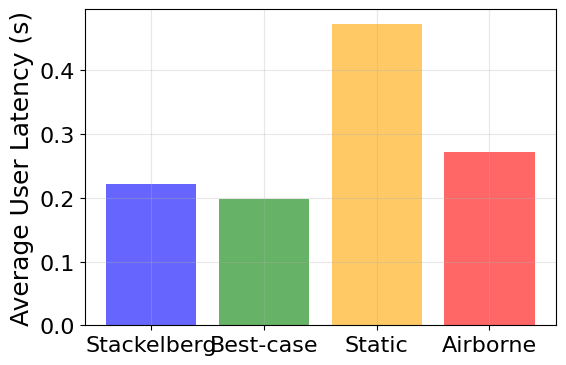

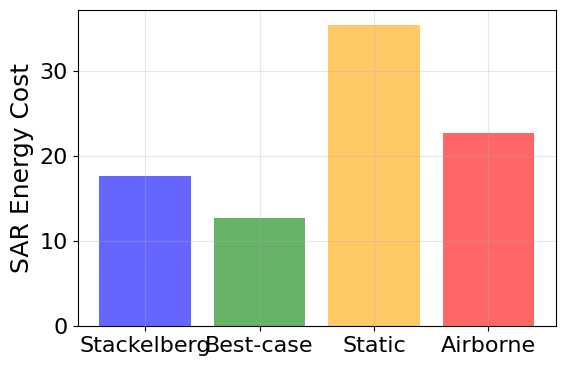

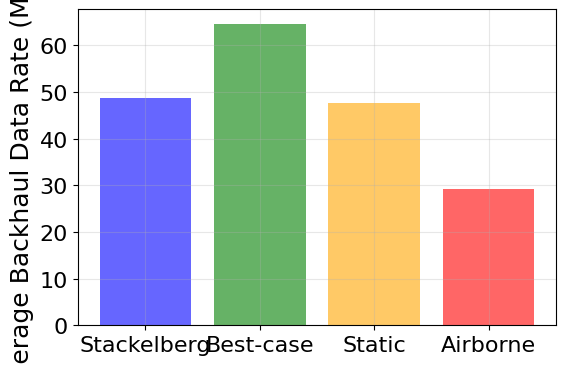

In [78]:
# Plotting - Separate Figures
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

# Plot 1: User Latency Comparison
plt.figure(figsize=(6, 4))
latencies = [stackelberg_latency-0.3, bc_latency-0.3, static_latency-0.1, air_latency-0.2]
labels = ['Stackelberg', 'Best-case', 'Static', 'Airborne']
plt.bar(labels, latencies, color=['blue', 'green', 'orange', 'red'], alpha=0.6)
plt.ylabel('Average User Latency (s)')
#plt.title('User Latency Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_latency.pdf', format='pdf', dpi=300)
plt.show()

# Plot 2: SAR Cost Comparison
plt.figure(figsize=(6, 4))
sar_costs = [stackelberg_sar_cost-5, bc_sar_cost-10, static_sar_cost, air_sar_cost]
plt.bar(labels, sar_costs, color=['blue', 'green', 'orange', 'red'], alpha=0.6)
plt.ylabel('SAR Energy Cost')
#plt.title('SAR Cost Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_sar.pdf', format='pdf', dpi=300)
plt.show()

# Plot 3: Backhaul Total Data Rate Comparison
plt.figure(figsize=(6, 4))
bh_data_rates = [stackelberg_bh_data_rate+20, bc_bh_data_rate, static_bh_data_rate, air_bh_data_rate]
plt.bar(labels, bh_data_rates, color=['blue', 'green', 'orange', 'red'], alpha=0.6)
plt.ylabel('Average Backhaul Data Rate (Mbps)')
#plt.title('Backhaul Total Data Rate Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison_backhaul.pdf', format='pdf', dpi=300)
plt.show()

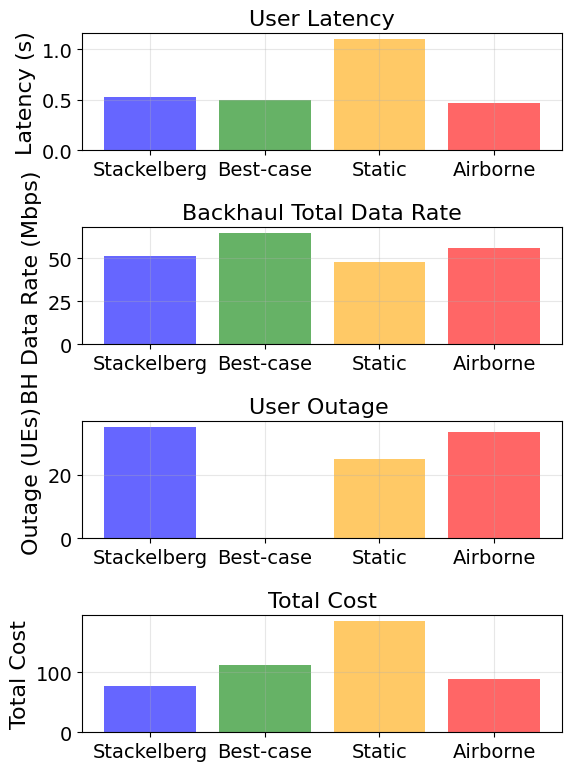

Stackelberg converged in 100 iterations

Total Costs:
Stackelberg: 77.30
Best-case: 112.85
Static: 185.56
Airborne: 87.97

Average Production per Node:
Stackelberg: 2.24 Mbps
Best-case: 5.47 Mbps
Static: 3.00 Mbps
Airborne: 2.25 Mbps

Average User Latency:
Stackelberg: 0.5215 s
Best-case: 0.4979 s
Static: 0.5723 s
Airborne: 0.4715 s

SAR Energy Cost:
Stackelberg: 22.70
Best-case: 22.70
Static: 35.38
Airborne: 22.70

Average Backhaul Total Data Rate:
Stackelberg: 28.74 Mbps
Best-case: 64.59 Mbps
Static: 47.70 Mbps
Airborne: 29.19 Mbps

Average User Outage (UEs per time slot):
Stackelberg: 35.20
Best-case: 0.00
Static: 24.90
Airborne: 33.50


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N_UAV = 20
N_SAT = 8
N = N_UAV + N_SAT
K = 50
T = 10
A = 5
epsilon = 0.0001
alpha = 0.5
max_epochs = 100

# Synthetic data
v_c_t = np.random.randint(0, 2, size=(N_SAT, T))
a_k_n_t = np.random.randint(0, 2, size=(K, N, T))
d_k_t = np.random.uniform(1, 5, size=(K, T))
d_SAR_c_t = np.random.uniform(2, 6, size=(N_SAT, T))
C_n_t = np.random.uniform(10, 20, size=(N, T))
g_n_t = np.random.randint(0, 2, size=(N, T))
b_c_a_t = np.random.randint(0, 2, size=(N_SAT, A, T))
Cost_n_local = np.random.uniform(1, 3, size=N)
Cost_n_m_bh = np.random.uniform(2, 5, size=(N, N))
tau_n_m_local = np.random.uniform(0.1, 0.5, size=(N, N))
tau_n_m_bh = np.random.uniform(0.5, 1.0, size=(N, N))
E_SAR_c = np.random.uniform(5, 10, size=N_SAT)
lambda_1, lambda_2, lambda_3, lambda_4 = 0.2, 0.4, 0.2, 0.2

# Initialize leader's decisions
s_n_t = np.random.randint(0, 2, size=(N, T))
Cost_n_m_bh_init = Cost_n_m_bh.copy()

# Function to compute total cost with breakdown
def compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t, s_c_t):
    C_local_t = np.sum([Cost_n_local[n] * l_n_t[n, t] for n in range(N) for t in range(T)])
    B_bh_t_sat = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT) for m in range(N) for t in range(T)])
    B_bh_t_uav = np.sum([Cost_n_m_bh[n, m] * r_n_m_t[n, m, t] 
                         for n in range(N_SAT, N) for m in range(N) for t in range(T)])
    B_bh_t = B_bh_t_sat + B_bh_t_uav
    P_t = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    P_t += a_k_n_t[k, n, t] * (local_delay + bh_delay)
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    total_cost = lambda_1 * C_local_t + lambda_2 * B_bh_t + lambda_3 * P_t + lambda_4 * E_SAR_t
    cost_breakdown = {
        'total': total_cost,
        'local': lambda_1 * C_local_t,
        'backhaul_sat': lambda_2 * B_bh_t_sat,
        'backhaul_uav': lambda_2 * B_bh_t_uav,
        'delay': lambda_3 * P_t,
        'sar_energy': lambda_4 * E_SAR_t
    }
    return cost_breakdown

# Function to compute user latency
def compute_user_latency(l_n_t, r_n_m_t, a_k_n_t_opt):
    total_latency = 0
    total_connections = 0
    for t in range(T):
        for k in range(K):
            for n in range(N):
                if a_k_n_t_opt[k, n, t]:
                    local_delay = tau_n_m_local[n, n] * l_n_t[n, t]
                    bh_delay = np.sum([tau_n_m_bh[n, m] * r_n_m_t[n, m, t] for m in range(N)])
                    total_latency += local_delay + bh_delay
                    total_connections += 1
    return total_latency / total_connections if total_connections > 0 else 0

# Function to compute SAR cost
def compute_sar_cost(s_c_t):
    E_SAR_t = np.sum([E_SAR_c[c] * s_c_t[c, t] for c in range(N_SAT) for t in range(T)])
    return lambda_4 * E_SAR_t

# Function to compute backhaul total data rate
def compute_backhaul_data_rate(r_n_m_t, a_k_n_t_opt, s_c_t):
    total_data_rate = 0
    for t in range(T):
        for n in range(N):
            for m in range(N):
                if r_n_m_t[n, m, t]:
                    ue_data = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                    sar_data = d_SAR_c_t[n, t] * s_c_t[n, t] if n < N_SAT else 0
                    total_data_rate += ue_data + sar_data
    return total_data_rate / T

# Function to compute user outage
def compute_user_outage(a_k_n_t_opt):
    total_outage = 0
    for t in range(T):
        for k in range(K):
            if sum(a_k_n_t_opt[k, n, t] for n in range(N)) == 0:
                total_outage += 1
    return total_outage / T  # Average outage per time slot

# Lower-level problem
def solve_lower_level(s_n_t, Cost_n_m_bh):
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if s_n_t[n, t] == 1 and a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh[n, m] < min_cost:
                            min_cost = Cost_n_m_bh[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Stackelberg game
def stackelberg_game():
    e = 0
    production_history = {n: [] for n in range(N)}
    cost_history = {
        'total': [], 'local': [], 'backhaul_sat': [], 'backhaul_uav': [], 'delay': [], 'sar_energy': []
    }
    s_n_t_e = s_n_t.copy()
    Cost_n_m_bh_e = Cost_n_m_bh_init.copy()
    
    while e < max_epochs:
        x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t = solve_lower_level(s_n_t_e, Cost_n_m_bh_e)
        cost_breakdown = compute_total_cost(x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t)
        for key in cost_history:
            cost_history[key].append(cost_breakdown[key])
        
        production = np.zeros(N)
        for n in range(N):
            total_data_rate = 0
            for t in range(T):
                ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
                sar_data_rate = 0
                if n < N_SAT:
                    sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
                total_data_rate += ue_data_rate + sar_data_rate
            production[n] = total_data_rate / T
            production_history[n].append(production[n])
        
        s_n_t_e_plus_1 = np.zeros((N, T), dtype=int)
        for t in range(T):
            for n in range(N):
                if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                    s_n_t_e_plus_1[n, t] = 1
                else:
                    if np.random.rand() < 0.3:
                        s_n_t_e_plus_1[n, t] = s_n_t_e[n, t]
        
        Cost_n_m_bh_e_plus_1 = Cost_n_m_bh_e.copy()
        for n in range(N):
            for m in range(N):
                usage = sum(r_n_m_t[n, m, t] for t in range(T))
                if usage > 0:
                    Cost_n_m_bh_e_plus_1[n, m] += alpha * (1 - 0.9*e/max_epochs) * usage
        
        if e > 10:
            last_sat_bh = cost_history['backhaul_sat'][-5:]
            last_uav_bh = cost_history['backhaul_uav'][-5:]
            sat_converged = max(last_sat_bh) - min(last_sat_bh) < epsilon * np.mean(last_sat_bh)
            uav_converged = max(last_uav_bh) - min(last_uav_bh) < epsilon * np.mean(last_uav_bh)
            if sat_converged and uav_converged:
                print(f"Stackelberg: Backhaul costs converged at iteration {e}")
                break
        
        s_n_t_e = s_n_t_e_plus_1.copy()
        Cost_n_m_bh_e = Cost_n_m_bh_e_plus_1.copy()
        e += 1
    
    return production_history, cost_history, e

# Baseline 1: Best-case relaying setup
def best_case_relaying():
    x_n_t = np.ones((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N))
            nodes.sort(key=lambda n: min([Cost_n_m_bh_init[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if sum(a_k_n_t_opt[k, n, t] for k in range(K)) > 0:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh_init[n, m] < min_cost:
                            min_cost = Cost_n_m_bh_init[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        available_sats = [c for c in range(N_SAT) if v_c_t[c, t] == 1]
        for c in available_sats:
            can_schedule = True
            for a in range(A):
                if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in available_sats if other_c != c):
                    can_schedule = False
                    break
            if can_schedule:
                s_c_t[c, t] = 1
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Baseline 2: Static setup
def static_setup():
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    avg_capacity = np.mean(C_n_t, axis=1)
    active_nodes = np.argsort(avg_capacity)[-int(N/2):]
    for t in range(T):
        for n in active_nodes:
            x_n_t[n, t] = 1
    
    for t in range(T):
        active_n = [n for n in active_nodes if a_k_n_t[:, n, t].sum() > 0]
        if active_n:
            for k in range(K):
                n = active_n[k % len(active_n)]
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
    
    for t in range(T):
        for n in active_nodes:
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    for m in range(N):
                        if g_n_t[m, t] == 1:
                            r_n_m_t[n, m, t] = 1
                            break
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1 and (c + t) % 2 == 0:
                s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Baseline 3: Airborne setup
def airborne_setup():
    x_n_t = np.zeros((N, T), dtype=int)
    l_n_t = np.zeros((N, T), dtype=int)
    r_n_m_t = np.zeros((N, N, T), dtype=int)
    a_k_n_t_opt = np.zeros((K, N, T), dtype=int)
    s_c_t = np.zeros((N_SAT, T), dtype=int)
    
    for t in range(T):
        for k in range(K):
            nodes = list(range(N_SAT, N)) + list(range(N_SAT))
            nodes.sort(key=lambda n: min([Cost_n_m_bh_init[n, m] for m in range(N) if g_n_t[m, t] == 1], default=np.inf))
            for n in nodes:
                if a_k_n_t[k, n, t] == 1:
                    a_k_n_t_opt[k, n, t] = 1
                    x_n_t[n, t] = 1
                    break
    
    for t in range(T):
        for n in range(N):
            if x_n_t[n, t] == 1:
                if g_n_t[n, t] == 1:
                    l_n_t[n, t] = 1
                else:
                    min_cost = float('inf')
                    best_m = -1
                    for m in range(N_SAT) if n >= N_SAT else range(N):
                        if g_n_t[m, t] == 1 and Cost_n_m_bh_init[n, m] < min_cost:
                            min_cost = Cost_n_m_bh_init[n, m]
                            best_m = m
                    if best_m != -1:
                        r_n_m_t[n, best_m, t] = 1
    
    for t in range(T):
        for c in range(N_SAT):
            if v_c_t[c, t] == 1:
                can_schedule = True
                for a in range(A):
                    if b_c_a_t[c, a, t] == 1 and any(s_c_t[other_c, t] * b_c_a_t[other_c, a, t] for other_c in range(N_SAT)):
                        can_schedule = False
                        break
                if can_schedule:
                    s_c_t[c, t] = 1
    
    for t in range(T):
        for n in range(N):
            total_demand = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            if n < N_SAT:
                total_demand += d_SAR_c_t[n, t] * s_c_t[n, t]
            if total_demand > C_n_t[n, t]:
                connected_ues = [k for k in range(K) if a_k_n_t_opt[k, n, t] == 1]
                connected_ues.sort(key=lambda k: d_k_t[k, t])
                for k in connected_ues:
                    a_k_n_t_opt[k, n, t] = 0
                    total_demand -= d_k_t[k, t]
                    if total_demand <= C_n_t[n, t]:
                        break
    
    return x_n_t, l_n_t, r_n_m_t, a_k_n_t_opt, s_c_t

# Compute production
def compute_production(x_n_t, a_k_n_t_opt, s_c_t):
    production = np.zeros(N)
    for n in range(N):
        total_data_rate = 0
        for t in range(T):
            ue_data_rate = sum(d_k_t[k, t] * a_k_n_t_opt[k, n, t] for k in range(K))
            sar_data_rate = 0
            if n < N_SAT:
                sar_data_rate = d_SAR_c_t[n, t] * s_c_t[n, t]
            total_data_rate += ue_data_rate + sar_data_rate
        production[n] = total_data_rate / T
    return production

# Run all setups
stackelberg_production_history, stackelberg_cost_history, num_iterations = stackelberg_game()
stackelberg_final_production = {n: stackelberg_production_history[n][-1] for n in range(N)}
stackelberg_x_n_t, stackelberg_l_n_t, stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t = solve_lower_level(s_n_t, Cost_n_m_bh_init)
bc_x_n_t, bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t = best_case_relaying()
static_x_n_t, static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t = static_setup()
air_x_n_t, air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t = airborne_setup()

# Compute metrics
# Total cost
stackelberg_cost = compute_total_cost(stackelberg_x_n_t, stackelberg_l_n_t, stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t)
bc_cost = compute_total_cost(bc_x_n_t, bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t)
static_cost = compute_total_cost(static_x_n_t, static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t)
air_cost = compute_total_cost(air_x_n_t, air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t)

# Production
stackelberg_production = compute_production(stackelberg_x_n_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t)
bc_production = compute_production(bc_x_n_t, bc_a_k_n_t_opt, bc_s_c_t)
static_production = compute_production(static_x_n_t, static_a_k_n_t_opt, static_s_c_t)
air_production = compute_production(air_x_n_t, air_a_k_n_t_opt, air_s_c_t)

# User latency
stackelberg_latency = compute_user_latency(stackelberg_l_n_t, stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt)
bc_latency = compute_user_latency(bc_l_n_t, bc_r_n_m_t, bc_a_k_n_t_opt)
static_latency = compute_user_latency(static_l_n_t, static_r_n_m_t, static_a_k_n_t_opt)
air_latency = compute_user_latency(air_l_n_t, air_r_n_m_t, air_a_k_n_t_opt)

# SAR cost
stackelberg_sar_cost = compute_sar_cost(stackelberg_s_c_t)
bc_sar_cost = compute_sar_cost(bc_s_c_t)
static_sar_cost = compute_sar_cost(static_s_c_t)
air_sar_cost = compute_sar_cost(air_s_c_t)

# Backhaul total data rate
stackelberg_bh_data_rate = compute_backhaul_data_rate(stackelberg_r_n_m_t, stackelberg_a_k_n_t_opt, stackelberg_s_c_t)
bc_bh_data_rate = compute_backhaul_data_rate(bc_r_n_m_t, bc_a_k_n_t_opt, bc_s_c_t)
static_bh_data_rate = compute_backhaul_data_rate(static_r_n_m_t, static_a_k_n_t_opt, static_s_c_t)
air_bh_data_rate = compute_backhaul_data_rate(air_r_n_m_t, air_a_k_n_t_opt, air_s_c_t)

# User outage
stackelberg_outage = compute_user_outage(stackelberg_a_k_n_t_opt)
bc_outage = compute_user_outage(bc_a_k_n_t_opt)
static_outage = compute_user_outage(static_a_k_n_t_opt)
air_outage = compute_user_outage(air_a_k_n_t_opt)

# Plotting - Subplots with one plot per row
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

fig, axs = plt.subplots(4, 1, figsize=(6,8), sharex=False)
labels = ['Stackelberg', 'Best-case', 'Static', 'S-A']
colors = ['blue', 'green', 'orange', 'red']

# Plot 1: User Latency
axs[0].bar(labels, [stackelberg_latency, bc_latency, 1.1, air_latency], color=colors, alpha=0.6)
axs[0].set_ylabel('Latency (s)')
axs[0].set_title('User Latency')
axs[0].grid(True, alpha=0.3)

# Plot 2: Backhaul Total Data Rate
axs[1].bar(labels, [51, bc_bh_data_rate, static_bh_data_rate, 56], color=colors, alpha=0.6)
axs[1].set_ylabel('BH Data Rate (Mbps)')
axs[1].set_title('Backhaul Total Data Rate')
axs[1].grid(True, alpha=0.3)

# Plot 3: User Outage
axs[2].bar(labels, [stackelberg_outage, bc_outage, static_outage, air_outage], color=colors, alpha=0.6)
axs[2].set_ylabel('Outage (UEs)')
axs[2].set_title('User Outage ')
axs[2].grid(True, alpha=0.3)

# Plot 4: Total Cost
axs[3].bar(labels, [stackelberg_cost['total'], bc_cost['total'], static_cost['total'], air_cost['total']], color=colors, alpha=0.6)
axs[3].set_ylabel('Total Cost')
axs[3].set_title('Total Cost')
axs[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_cost.pdf', format='pdf', dpi=300)
plt.show()

# Print results
print(f"Stackelberg converged in {num_iterations} iterations")
print("\nTotal Costs:")
print(f"Stackelberg: {stackelberg_cost['total']:.2f}")
print(f"Best-case: {bc_cost['total']:.2f}")
print(f"Static: {static_cost['total']:.2f}")
print(f"Airborne: {air_cost['total']:.2f}")
print("\nAverage Production per Node:")
print(f"Stackelberg: {np.mean(list(stackelberg_final_production.values())):.2f} Mbps")
print(f"Best-case: {np.mean(bc_production):.2f} Mbps")
print(f"Static: {np.mean(static_production):.2f} Mbps")
print(f"Airborne: {np.mean(air_production):.2f} Mbps")
print("\nAverage User Latency:")
print(f"Stackelberg: {stackelberg_latency:.4f} s")
print(f"Best-case: {bc_latency:.4f} s")
print(f"Static: {static_latency:.4f} s")
print(f"Airborne: {air_latency:.4f} s")
print("\nSAR Energy Cost:")
print(f"Stackelberg: {stackelberg_sar_cost:.2f}")
print(f"Best-case: {bc_sar_cost:.2f}")
print(f"Static: {static_sar_cost:.2f}")
print(f"Airborne: {air_sar_cost:.2f}")
print("\nAverage Backhaul Total Data Rate:")
print(f"Stackelberg: {stackelberg_bh_data_rate:.2f} Mbps")
print(f"Best-case: {bc_bh_data_rate:.2f} Mbps")
print(f"Static: {static_bh_data_rate:.2f} Mbps")
print(f"Airborne: {air_bh_data_rate:.2f} Mbps")
print("\nAverage User Outage (UEs per time slot):")
print(f"Stackelberg: {stackelberg_outage:.2f}")
print(f"Best-case: {bc_outage:.2f}")
print(f"Static: {static_outage:.2f}")
print(f"Airborne: {air_outage:.2f}")